In [42]:
import os, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch_geometric.data import HeteroData
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader 
import random
from typing import List, Tuple, Dict, Iterable
from torch_geometric.data import Batch, Data
import matplotlib.pyplot as plt
import pandas as pd
import h5py

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)
rng = np.random.default_rng(7)

# Config 

In [351]:
@dataclass
class SimCfg:
    R: float = 200.0
    P_max: float = 200.0
    S_L: float = 1.0
    S_W: float = 0.75
    c_price: float = 0.1
    select_u: float = 0.4
    L_thr: float = 0.3
    B: float = 10**6
    n0: float = None         
    Fs: int = 3                
    K: int = 3             
    N: int = 5

In [45]:
def pathloss_gain(d):
    return -(120.9 + 37.6 * np.log10(d / 1000.0)) + np.random.normal(0.0, 7.0)

In [46]:
def calculate_channel_matrix(distances, is_bs: bool):
    d = distances.reshape(-1, 1) if is_bs else distances
    pathloss = pathloss_gain(d)
    small_scale = np.random.normal(1, size=d.shape) ** 2
    channel_gain = 10 ** (pathloss / 10.0) * small_scale
    return np.abs(channel_gain).astype(np.float32)

In [47]:
class StandardScalerNP:
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = X.mean(0)
        self.std_ = X.std(0)
        self.std_[self.std_==0]=1.0
    def transform(self, X): return (X-self.mean_)/self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# Generate dataset 

In [48]:
# # -------------------------------
# # Environment Setup
# # -------------------------------
# R = 200
# P_max = 200
# S_L = 1         # LTE satisfaction per unit rate
# S_W = 0.75      # WiFi satisfaction per unit rate



# c = 0.1         # Cost per unit data rate
# B = 10**6       # Bandwidth
# n0 = B * 10**-17.4  # Noise power

# F = 3          # Number of subchannels
# K = 3           # Number of WiFi APs
# N = 5           # Number of users

# bs_location = np.array([R, R])
# user_locations = []
# ap_locations = []
# C_i = []         # User affordability
# L_thr = []       # Satisfaction thresholds

# # Random affordability for 40% of users
# selected_users = set(random.sample(range(N), int(N * 0.4)))

# for i in range(N):
#     L_thr.append(0.3)
#     x, y = np.random.uniform(0, 2 * R, size=2)
#     user_locations.append([x, y])
#     C = np.random.uniform(5, 10) if i in selected_users else 0
#     C_i.append(C)

# for i in range(K):
#     x, y = np.random.uniform(0, 2 * R, size=2)
#     ap_locations.append([x, y])

# user_locations = np.array(user_locations)
# ap_locations = np.array(ap_locations)

# # -------------------------------
# # Channel Calculation
# # -------------------------------

# def calculate_channel_matrix(distances, is_bs):
#     if is_bs:
#         distances = distances.reshape(-1, 1)
#     pathloss = -(120.9 + 37.6 * np.log10(distances / 1000)) + \
#                7 * np.random.normal(1, size=distances.shape)
#     small_scale = np.random.normal(1, size=distances.shape)**2
#     channel_gain = 10 ** (pathloss / 10) * small_scale
#     return np.abs(channel_gain)

# d_user_ap = np.linalg.norm(user_locations[:, None] - ap_locations, axis=2)
# d_user_bs = np.linalg.norm(user_locations - bs_location, axis=1)
# h_ik = calculate_channel_matrix(d_user_ap, is_bs=False)
# h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).flatten()

# # -------------------------------
# # Random Fixed Assignments: X, Ψ, q
# # -------------------------------

# X_iL = np.zeros(N)
# X_ik = np.zeros((N, K))
# Psi = np.zeros((N, F))
# q = np.random.randint(0, 2, N)  # Random satisfaction indicator

# for i in range(N):
#     sel = np.random.choice(K + 1)
#     if sel == K:
#         X_iL[i] = 1
#     else:
#         X_ik[i, sel] = 1
#     Psi[i, np.random.choice(F)] = 1

## HomoGraph

In [49]:
# def generate_dataset(cfg: SimCfg, seed: int = 7, standardize: bool = True):
#     random.seed(seed)
#     n0 = cfg.B * 10**-17.4 if (cfg.n0 is None) else cfg.n0
#     bs_location = np.array([cfg.R, cfg.R], dtype=np.float32)

#     user_locations, ap_locations = [], []
#     C_i, L_thr = [], []
#     selected_users = set(random.sample(range(cfg.N), max(1, int(cfg.N * 0.4))))

#     for i in range(cfg.N):
#         L_thr.append(0.3)
#         x, y = np.random.uniform(0, 2 * cfg.R, size=2)
#         user_locations.append([x, y])
#         C = np.random.uniform(5, 10) if i in selected_users else 0.0
#         C_i.append(C)

#     for i in range(cfg.K):
#         x, y = np.random.uniform(0, 2 * cfg.R, size=2)
#         ap_locations.append([x, y])

#     user_locations = np.array(user_locations, dtype=np.float32)
#     ap_locations   = np.array(ap_locations,   dtype=np.float32)
#     C_i  = np.array(C_i,  dtype=np.float32)
#     L_thr= np.array(L_thr,dtype=np.float32)

#     # -------------------------------
#     # Channel Calculation
#     # -------------------------------

#     d_user_ap = np.linalg.norm(user_locations[:, None] - ap_locations[None, :], axis=2)  # (N,K)
#     d_user_bs = np.linalg.norm(user_locations - bs_location, axis=1)                     # (N,)
#     h_ik = calculate_channel_matrix(d_user_ap, is_bs=False)                               # (N,K)
#     h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).flatten()                      # (N,)

#     # -------------------------------
#     # Random Fixed Assignments: X, Ψ, q
#     # -------------------------------
#     X_iL = np.zeros(cfg.N, dtype=np.int64)
#     X_ik = np.zeros((cfg.N, cfg.K), dtype=np.int64)
#     Psi  = np.zeros((cfg.N, cfg.Fs), dtype=np.int64)
#     q    = np.random.randint(0, 2, cfg.N).astype(np.int64)  # Random satisfaction indicator

#     subband_idx = np.zeros(cfg.N, dtype=np.int64)
#     ap_idx      = -np.ones(cfg.N, dtype=np.int64)  # -1 nếu LTE

#     for i in range(cfg.N):
#         sel = np.random.choice(cfg.K + 1)  # {0..K-1}=AP, K=LTE
#         if sel == cfg.K:
#             X_iL[i] = 1
#             ap_idx[i] = -1
#         else:
#             X_ik[i, sel] = 1
#             ap_idx[i] = sel
#         f = np.random.choice(cfg.Fs)
#         Psi[i, f] = 1
#         subband_idx[i] = f

#     # -------------------------------
#     # Interference matrix Hbar
#     Hbar = np.zeros((cfg.N, cfg.N), dtype=np.float32)
#     for i in range(cfg.N):
#         if X_iL[i] == 1:
#             Hbar[i, :] = h_iL[:]
#         else:
#             kstar = ap_idx[i]
#             Hbar[i, :] = h_ik[:, kstar]
#     np.fill_diagonal(Hbar, 0.0)

#     # -------------------------------
#     # Build graph edges
#     # -------------------------------
#     P_vec = np.full(cfg.N, cfg.P_max, dtype=np.float32) 
#     edge_src, edge_dst, edge_w = [], [], []
#     for f in range(cfg.Fs):
#         ids = np.where(subband_idx == f)[0]
#         if ids.size <= 1:
#             continue
#         for a in ids:
#             for b in ids:
#                 if a == b: 
#                     continue
#                 w = P_vec[b] * Hbar[a, b]
#                 edge_src.append(a); edge_dst.append(b); edge_w.append(float(w))

#     edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
#     edge_weight = torch.tensor(edge_w, dtype=torch.float32)


#     feat_cols = ["Pmax", "Ci", "Lthr", "h_iL"] + [f"h_i{k}" for k in range(cfg.K)]
#     df = pd.DataFrame({
#         "Pmax": P_vec,
#         "Ci":   C_i,
#         "Lthr": L_thr,
#         "h_iL": h_iL
#     })
#     for k in range(cfg.K):
#         df[f"h_i{k}"] = h_ik[:, k]
#     df["subband"] = subband_idx
#     df["x_LTE"]   = X_iL
#     df["ap_idx"]  = ap_idx
#     df["q"]       = q

#     X_np = df[feat_cols].to_numpy(np.float32)
#     if standardize:
#         X_mean = X_np.mean(axis=0); X_std = X_np.std(axis=0); X_std[X_std == 0] = 1.0
#         X_np = (X_np - X_mean) / X_std

#     # if standardize:
#     #     X_mean = X_np.mean(axis=0)
#     #     X_std  = X_np.std(axis=0)
#     #     X_std[X_std == 0] = 1.0
#     #     ci_idx = feat_cols.index("Ci")
#     #     X_mean[ci_idx] = 0.0  
#     #     X_std[ci_idx]  = 1.0 

#     data = Data(
#         x=torch.tensor(X_np, dtype=torch.float32),
#         edge_index=edge_index,
#         edge_weight=edge_weight
#     )

#     aux = {
#         "g_iL": torch.tensor(h_iL, dtype=torch.float32),
#         "g_ik": torch.tensor(h_ik, dtype=torch.float32),
#         "Pmax": torch.tensor(np.full(cfg.N, cfg.P_max, dtype=np.float32), dtype=torch.float32),
#         "Ci":   torch.tensor(C_i, dtype=torch.float32),
#         "Lthr": torch.tensor(L_thr, dtype=torch.float32),
#         "noise": torch.tensor(float(n0), dtype=torch.float32),
#         "SL": torch.tensor(float(cfg.S_L), dtype=torch.float32),
#         "SW": torch.tensor(float(cfg.S_W), dtype=torch.float32),
#         "cprice": torch.tensor(float(cfg.c_price), dtype=torch.float32),
#         "N": cfg.N, "K": cfg.K, "F": cfg.Fs,
#         "X_iL": torch.tensor(X_iL, dtype=torch.int64),
#         "X_ik": torch.tensor(X_ik, dtype=torch.int64),
#         "Psi":  torch.tensor(Psi,  dtype=torch.int64),
#         "q":    torch.tensor(q,    dtype=torch.int64),
#         "subband_idx": torch.tensor(subband_idx, dtype=torch.int64),
#         "ap_idx":      torch.tensor(ap_idx,      dtype=torch.int64),
#         "user_xy": torch.tensor(user_locations, dtype=torch.float32),
#         "ap_xy":   torch.tensor(ap_locations,   dtype=torch.float32),
#         "bs_xy":   torch.tensor([cfg.R, cfg.R], dtype=torch.float32)
#     }

#     return df, data, aux


In [50]:
# def build_fixed_batches(cfg, num_scenarios=1000, batch_size=64, start_seed=7, standardize: bool = True):
#     scenarios = []
#     for i in range(num_scenarios):
#         seed = start_seed + i
#         df_i, data_i, aux_i = generate_dataset(cfg, seed=seed, standardize = standardize)
#         scenarios.append((df_i, data_i, aux_i))

#     batches = []
#     for start in range(0, len(scenarios), batch_size):
#         chunk = scenarios[start:start+batch_size]
#         data_list = [d for (_, d, _) in chunk]
#         aux_list  = [a for (_, _, a) in chunk]
#         batched = Batch.from_data_list(data_list)     
#         batches.append((batched, aux_list))

#     return batches

## HetoGraph

In [352]:
def generate_dataset_bipartite(cfg, seed: int = 7, standardize: bool = True):
    rng = np.random.default_rng(seed)
    random.seed(seed)
    n0 = cfg.B * 10**-17.4 if (getattr(cfg, "n0", None) is None) else float(cfg.n0)
    bs_xy = np.array([cfg.R, cfg.R], dtype=np.float32)                    
    ap_xy = rng.uniform(0, 2 * cfg.R, size=(cfg.K, 2)).astype(np.float32)  
    user_xy = rng.uniform(0, 2 * cfg.R, size=(cfg.N, 2)).astype(np.float32)
    d_user_bs = np.linalg.norm(user_xy - bs_xy[None, :], axis=1)         
    d_user_ap = np.linalg.norm(user_xy[:, None, :] - ap_xy[None, :, :], axis=2) 
    h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).astype(np.float32).flatten()  
    h_ik = calculate_channel_matrix(d_user_ap, is_bs=False).astype(np.float32)           
    C_i, L_thr = [], []
    selected_users = set(random.sample(range(cfg.N), max(1, int(cfg.N * cfg.select_u))))
    Lthr = cfg.L_thr if cfg.L_thr is not None else 0.3
    for i in range(cfg.N):
        L_thr.append(Lthr)
        # C = np.random.uniform(5, 10) if i in selected_users else 0.0
        C = (5 + (10 - 5) * np.random.rand()) if i in selected_users else 0.0
        C_i.append(C)
    C_i   = np.array(C_i,   dtype=np.float32)  
    L_thr = np.array(L_thr, dtype=np.float32)  
    Pmax_users = np.full(cfg.N, 1.0, dtype=np.float32)  

    data = HeteroData()
    user_feats = np.stack([Pmax_users, C_i, L_thr], axis=1).astype(np.float32) 
    if standardize:
        mu = user_feats.mean(axis=0); std = user_feats.std(axis=0); std[std == 0] = 1.0
        user_feats = (user_feats - mu) / std
    data["user"].x = torch.tensor(user_feats, dtype=torch.float32)
    data["user"].pos = torch.tensor(user_xy, dtype=torch.float32)
    infra_flag = np.concatenate([np.array([[1.0]], dtype=np.float32),
                                 np.zeros((cfg.K, 1), dtype=np.float32)], axis=0) 
    infra_xy = np.vstack([bs_xy[None, :], ap_xy]).astype(np.float32)                
    data["infra"].x = torch.tensor(infra_flag, dtype=torch.float32)
    data["infra"].pos = torch.tensor(infra_xy, dtype=torch.float32)
    edge_src, edge_dst = [], []
    edge_attr_list = [] 

    for i in range(cfg.N):
        g = float(h_iL[i])
        d = float(d_user_bs[i])
        pl_db = pathloss_gain(d)
        link_type = 1.0  # LTE/BS
        noise_local = n0
        edge_src.append(i)
        edge_dst.append(0)
        edge_attr_list.append([d, g, pl_db, cfg.c_price, n0])

    for i in range(cfg.N):
        for k in range(cfg.K):
            g = float(h_ik[i, k])
            d = float(d_user_ap[i, k])
            pl_db = pathloss_gain(d)
            link_type = 0.0  # AP
            noise_local = n0
            edge_src.append(i)
            edge_dst.append(1 + k)
            edge_attr_list.append([d, g, pl_db, link_type, n0])

    edge_index_u2i = torch.tensor([edge_src, edge_dst], dtype=torch.long)          # (2,E)
    edge_attr      = torch.tensor(edge_attr_list, dtype=torch.float32)             # (E,5)
    # mean = edge_attr.mean(dim=0, keepdim=True)
    # std  = edge_attr.std(dim=0, keepdim=True)
    # std[std == 0] = 1.0
    # edge_attr = (edge_attr - mean) / std

    data["user", "link", "infra"].edge_index = edge_index_u2i
    data["user", "link", "infra"].edge_attr  = edge_attr

    # reverse edges (infra -> user) + same attributes
    data["infra", "rev_link", "user"].edge_index = edge_index_u2i.flip(0)
    data["infra", "rev_link", "user"].edge_attr  = edge_attr
    
    data["meta"].fs = torch.tensor([cfg.Fs], dtype=torch.long)
   
    feat_cols = ["Pmax", "Ci", "Lthr", "h_iL"] + [f"h_i{k}" for k in range(cfg.K)]
    df = pd.DataFrame({
        "uid":  np.arange(cfg.N, dtype=np.int64),
        "Pmax": Pmax_users,
        "Ci":   C_i,
        "Lthr": L_thr,
        "h_iL": h_iL.astype(np.float32),
        "x":    user_xy[:, 0].astype(np.float32),
        "y":    user_xy[:, 1].astype(np.float32),
    })
    for k in range(cfg.K):
        df[f"h_i{k}"] = h_ik[:, k].astype(np.float32)

    # -------------------------------
    # Placeholders (giữ nguyên API cũ)
    # -------------------------------
    X_iL = np.zeros(cfg.N, dtype=np.int64)
    X_ik = np.zeros((cfg.N, cfg.K), dtype=np.int64)
    Psi  = np.zeros((cfg.N, cfg.Fs), dtype=np.int64)
    q    = np.zeros(cfg.N, dtype=np.int64)
    subband_idx = np.zeros(cfg.N, dtype=np.int64)
    ap_idx      = -np.ones(cfg.N, dtype=np.int64)

    # -------------------------------
    # aux (đủ khoá cũ, thêm mô tả edge features)
    # -------------------------------
    aux = {
        # channels
        "g_iL": torch.tensor(h_iL, dtype=torch.float32),
        "g_ik": torch.tensor(h_ik, dtype=torch.float32),

        # power / service
        "Pmax": torch.tensor(Pmax_users, dtype=torch.float32),
        "Ci":   torch.tensor(C_i, dtype=torch.float32),
        "Lthr": torch.tensor(L_thr, dtype=torch.float32),
        "noise": torch.tensor(n0, dtype=torch.float32),
        "SL": torch.tensor(float(cfg.S_L), dtype=torch.float32),
        "SW": torch.tensor(float(cfg.S_W), dtype=torch.float32),
        "cprice": torch.tensor(float(cfg.c_price), dtype=torch.float32),

        # sizes
        "N": cfg.N, "K": cfg.K, "F": cfg.Fs,

        # placeholders
        "X_iL": torch.tensor(X_iL, dtype=torch.int64),
        "X_ik": torch.tensor(X_ik, dtype=torch.int64),
        "Psi":  torch.tensor(Psi,  dtype=torch.int64),
        "q":    torch.tensor(q,    dtype=torch.int64),
        "subband_idx": torch.tensor(subband_idx, dtype=torch.int64),
        "ap_idx":      torch.tensor(ap_idx,      dtype=torch.int64),

        # geometry
        "user_xy": torch.tensor(user_xy, dtype=torch.float32),
        "ap_xy":   torch.tensor(ap_xy,   dtype=torch.float32),
        "bs_xy":   torch.tensor(bs_xy,   dtype=torch.float32),

        # edge feature description (tiện debug/giải thích)
        "edge_feature_names": ["gain", "distance", "pathloss_dB", "link_type", "noise"]
    }

    return df[["uid"] + feat_cols + ["x", "y"]], data, aux


In [52]:
def build_fixed_batches_bipartite(
    cfg,
    num_scenarios: int = 1000,
    batch_size: int = 64,
    start_seed: int = 7,
    standardize: bool = True
):
    scenarios = []
    for i in range(num_scenarios):
        seed = start_seed + i
        df_i, data_i, aux_i = generate_dataset_bipartite(
            cfg, seed=seed, standardize=standardize
        )
        scenarios.append((data_i, aux_i))

    batches = []

    data_list = [d for (d, _) in scenarios]           
    aux_list_all = [a for (_, a) in scenarios]       
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)

    for b_idx, batched_graph in enumerate(loader):
        start = b_idx * batch_size
        end = min(start + batch_size, len(aux_list_all))
        aux_chunk = aux_list_all[start:end]
        batches.append((batched_graph, aux_chunk))

    return batches

In [353]:
cfg = SimCfg(R=200, P_max=200, S_L=1.0, S_W=0.75, c_price=0.1, B=10**6, n0=None, Fs=3, K=3, N=5, select_u=0.4)
batches = build_fixed_batches_bipartite(cfg, num_scenarios=2000, batch_size=64, start_seed=37, standardize = True)
print(f"Số batch cố định: {len(batches)}")

Số batch cố định: 32


In [354]:
cfg.L_thr

0.3

# Policy-GCN

In [54]:
# class PolicyGCN(nn.Module):
#     def __init__(self, in_dim, hidden, K, Fs):
#         super().__init__()
#         self.conv1 = GCNConv(in_dim, hidden)
#         self.conv2 = GCNConv(hidden, hidden)
#         self.conv3 = GCNConv(hidden, hidden)

#         self.mlp_ci = nn.Sequential(
#             nn.Linear(1, 16),
#             nn.ReLU(),
#             nn.Linear(16, hidden)
#         )
#         self.recv_head = nn.Linear(hidden, K+1)  
#         self.band_head = nn.Linear(hidden, Fs)
#         self.pow_head  = nn.Linear(hidden, 1)
#     def forward(self, x, edge_index, edge_weight=None):
#         h = self.conv1(x, edge_index, edge_weight=edge_weight)
#         h = F.relu(h)
#         h = self.conv2(h, edge_index, edge_weight=edge_weight)
#         h = F.relu(h)
#         h = self.conv3(h, edge_index, edge_weight=edge_weight)
#         h = F.relu(h)
#         recv_logits = self.recv_head(h)
#         Ci = x[:, 1].unsqueeze(1)
#         ci_embedding = self.mlp_ci(Ci)
#         recv_logits = self.recv_head(h+ci_embedding)

#         band_logits = self.band_head(h)
#         pow_logit   = self.pow_head(h).squeeze(-1)  # (N,)
#         w_rx = F.softmax(recv_logits, dim=-1)    # (N, K+1)
#         p_f  = F.softmax(band_logits, dim=-1)    # (N, F)
#         a    = torch.sigmoid(pow_logit)          # (N,)
#         return w_rx, p_f, a

In [55]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import HeteroConv, SAGEConv
# from torch_scatter import scatter_softmax


# # ===================================================
# # EdgeGate — dùng 5 chiều edge_attr từ dataset mới
# # ===================================================
# class EdgeGate(nn.Module):
#     def __init__(self, in_dim=5, hidden=32):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(in_dim, hidden),
#             nn.ReLU(),
#             nn.Linear(hidden, 1)
#         )

#     def forward(self, edge_attr):
#         if edge_attr.dim() == 1:
#             edge_attr = edge_attr.unsqueeze(-1)
#         return torch.sigmoid(self.mlp(edge_attr))  # (E, 1)



# class PolicyHetero(nn.Module):
#     def __init__(self, user_in, infra_in, hidden, Fs, K_plus_1):
#         super().__init__()
#         self.Kp1 = K_plus_1

#         # Node encoders
#         self.user_enc  = nn.Linear(user_in,  hidden)
#         self.infra_enc = nn.Linear(infra_in, hidden)

#         def sage():
#             return SAGEConv((hidden, hidden), hidden, aggr="mean")

#         self.gnn_layers = nn.ModuleList([
#             HeteroConv({
#                 ("user", "link", "infra"): sage(),
#                 ("infra", "rev_link", "user"): sage(),
#             }, aggr="mean")
#             for _ in range(3)
#         ])

#         # Edge gating
#         self.edge_gate_ui = EdgeGate(in_dim=4, hidden=64)
#         self.edge_gate_iu = EdgeGate(in_dim=4, hidden=64)

#         # Association scoring
#         self.recv_user_proj  = nn.Linear(hidden, hidden, bias=False)
#         self.recv_infra_proj = nn.Linear(hidden, hidden, bias=False)
#         self.gain_bias = nn.Linear(1, 1, bias=False)

#         # Heads
#         self.band_head = nn.Linear(hidden, Fs)
#         self.pow_head  = nn.Linear(hidden, 1)

#         # Budget embedding
#         self.mlp_ci = nn.Sequential(
#             nn.Linear(1, hidden),
#             nn.ReLU(),
#            # nn.Linear(16, hidden)
#         )

#     def forward(self, data):
#         x_user  = F.relu(self.user_enc(data["user"].x))
#         x_infra = F.relu(self.infra_enc(data["infra"].x))
#         for layer in self.gnn_layers:
#             out = layer(
#                 x_dict={"user": x_user, "infra": x_infra},
#                 edge_index_dict={
#                     ("user", "link", "infra"): data["user", "link", "infra"].edge_index,
#                     ("infra", "rev_link", "user"): data["infra", "rev_link", "user"].edge_index,
#                 }
#             )
#             x_user  = F.relu(out["user"])
#             x_infra = F.relu(out["infra"])

#         # Add Ci embedding (user budget info)
#         Ci = data["user"].x[:, 0:1]
#         x_user = x_user + self.mlp_ci(Ci)

#         # Heads: band + power
#         band_probs = F.softmax(self.band_head(x_user), dim=-1)
#         power      = torch.sigmoid(self.pow_head(x_user).squeeze(-1))

#         # Association prediction
#         ei = data["user", "link", "infra"].edge_index
#         u_idx, i_idx = ei
#         edge_attr = data["user", "link", "infra"].edge_attr  # (E, 5)
#         gain = edge_attr[:, 0:1]

#         Hu = self.recv_user_proj(x_user)[u_idx]
#         Hi = self.recv_infra_proj(x_infra)[i_idx]

#         # Apply gating
#         edge_gate_w = self.edge_gate_ui(edge_attr)
#         edge_score = (Hu * Hi).sum(-1, keepdim=True) + self.gain_bias(gain)
#         edge_score = edge_score * edge_gate_w

#         # Softmax per user per graph
#         ub = data["user"].batch[u_idx]
#         group_id = ub * (x_user.size(0) + 1) + u_idx
#         edge_prob = scatter_softmax(edge_score.squeeze(-1), group_id)

#         # Reconstruct (Nu, K+1) association matrix
#         U_batch = data["user"].batch
#         I_batch = data["infra"].batch
#         num_graphs = int(U_batch.max().item()) + 1

#         recv_probs_list = []
#         for g in range(num_graphs):
#             u_mask = (U_batch == g)
#             i_mask = (I_batch == g)
#             u_ids = u_mask.nonzero(as_tuple=False).view(-1)
#             i_ids = i_mask.nonzero(as_tuple=False).view(-1)
#             e_mask = (ub == g)

#             Nu_g = u_ids.numel()
#             mat = x_user.new_zeros((Nu_g, self.Kp1))

#             u_e = u_idx[e_mask]
#             i_e = i_idx[e_mask]
#             p_e = edge_prob[e_mask]

#             u_map = -torch.ones_like(U_batch)
#             i_map = -torch.ones_like(I_batch)
#             u_map[u_ids] = torch.arange(Nu_g, device=x_user.device)
#             i_map[i_ids] = torch.arange(self.Kp1, device=x_user.device)

#             ur = u_map[u_e]
#             ir = i_map[i_e]
#             mat.index_put_((ur, ir), p_e, accumulate=True)
#             recv_probs_list.append(mat)

#         recv_probs = torch.cat(recv_probs_list, dim=0)
#         return recv_probs, band_probs, power


In [56]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import HeteroConv, SAGEConv
# from torch_scatter import scatter_softmax
# import math

# # ============================================================
# # EdgeGate — giữ nguyên
# # ============================================================
# class EdgeGate(nn.Module):
#     def __init__(self, in_dim=4, hidden=32):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(in_dim, hidden),
#             nn.ReLU(),
#             nn.Linear(hidden, 1)
#         )
#     def forward(self, edge_attr):
#         if edge_attr.dim() == 1:
#             edge_attr = edge_attr.unsqueeze(-1)
#         return torch.sigmoid(self.mlp(edge_attr))  # (E, 1)


# # ============================================================
# # DynamicBandHead (phiên bản ổn định, không bias theo index)
# # ============================================================
# class DynamicBandHead(nn.Module):
#     def __init__(self, hidden: int, fourier_dim: int = 8):
#         super().__init__()
#         self.hidden = hidden
#         self.fourier_dim = fourier_dim
#         self.user_proj = nn.Linear(hidden, hidden, bias=False)
#         self.sub_proj  = nn.Linear(2 * fourier_dim, hidden, bias=False)
#         self.scale = nn.Parameter(torch.tensor(1.0))

#         # Tần số Fourier cố định (buffer)
#         freqs = torch.exp(torch.linspace(math.log(1.0), math.log(100.0), fourier_dim))
#         self.register_buffer("freqs", freqs, persistent=False)

#     def _subband_features(self, Fs: int, device: torch.device):
#         # normalize chỉ số subband về [-1,1]
#         idx = torch.arange(Fs, device=device, dtype=torch.float32)
#         x = (2.0 * (idx / Fs - 1) - 1.0).unsqueeze(-1)
#         ang = x * self.freqs.view(1, -1) * 2.0 * math.pi
#         feats = torch.cat([torch.sin(ang), torch.cos(ang)], dim=-1)
#         return F.layer_norm(feats, (feats.size(-1),))  # normalize năng lượng

#     def forward_logits(self, x_user: torch.Tensor, Fs: int):
#         """Trả về logits để huấn luyện hoặc hiệu chỉnh tải."""
#         Q = F.normalize(self.user_proj(x_user), p=2, dim=-1)  # (U,H)
#         K = F.normalize(self.sub_proj(self._subband_features(Fs, x_user.device)), p=2, dim=-1)  # (Fs,H)
#         logits = self.scale * (Q @ K.t())                     # (U,Fs)
#         return logits

#     def forward(self, x_user: torch.Tensor, Fs: int, temperature: float = 1.0):
#         logits = self.forward_logits(x_user, Fs)
#         return F.softmax(logits / temperature, dim=-1)


# class PolicyHetero(nn.Module):
#     def __init__(self, user_in, infra_in, hidden):
#         super().__init__()
#         self.hidden = hidden
#         self.user_enc  = nn.Linear(user_in,  hidden)
#         self.infra_enc = nn.Linear(infra_in, hidden)

#         def sage():
#             return SAGEConv((hidden, hidden), hidden, aggr="mean")

#         # 3 tầng GNN hai chiều
#         self.gnn_layers = nn.ModuleList([
#             HeteroConv({
#                 ("user", "link", "infra"): sage(),
#                 ("infra", "rev_link", "user"): sage(),
#             }, aggr="mean")
#             for _ in range(3)
#         ])

#         # Edge gating (4 chiều edge_attr: [gain, pl_db, link_type, noise])
#         self.edge_gate_ui = EdgeGate(in_dim=4, hidden=32)
#         self.edge_gate_iu = EdgeGate(in_dim=4, hidden=32)

#         # Association scoring
#         self.recv_user_proj  = nn.Linear(hidden, hidden, bias=False)
#         self.recv_infra_proj = nn.Linear(hidden, hidden, bias=False)
#         self.gain_bias = nn.Linear(1, 1, bias=False)

#         # Heads
#         self.band_head = DynamicBandHead(hidden, fourier_dim=8)
#         self.pow_head  = nn.Linear(hidden, 1)

#         # Budget embedding (Ci)
#         self.mlp_ci = nn.Sequential(
#             nn.Linear(1, 16),
#             nn.ReLU(),
#             nn.Linear(16, hidden)
#         )

#     # ============================================================
#     # Forward
#     # ============================================================
#     def forward(self, data, temperature: float = 1.0, beta_load: float = 0.0):
#         x_user  = F.relu(self.user_enc(data["user"].x))
#         x_infra = F.relu(self.infra_enc(data["infra"].x))

#         # --- GNN ---
#         for layer in self.gnn_layers:
#             out = layer(
#                 x_dict={"user": x_user, "infra": x_infra},
#                 edge_index_dict={
#                     ("user", "link", "infra"): data["user", "link", "infra"].edge_index,
#                     ("infra", "rev_link", "user"): data["infra", "rev_link", "user"].edge_index,
#                 }
#             )
#             x_user  = F.relu(out["user"])
#             x_infra = F.relu(out["infra"])

#         # --- Budget embedding ---
#         Ci = data["user"].x[:, 0:1]
#         x_user = x_user * self.mlp_ci(Ci)

#         # --- Power head ---
#         power = torch.sigmoid(self.pow_head(x_user).squeeze(-1)) 

#         ei = data["user", "link", "infra"].edge_index
#         u_idx, i_idx = ei
#         edge_attr = data["user", "link", "infra"].edge_attr
#         gain = edge_attr[:, 0:1]

#         Hu = self.recv_user_proj(x_user)[u_idx]
#         Hi = self.recv_infra_proj(x_infra)[i_idx]
#         edge_gate_w = self.edge_gate_ui(edge_attr[:, :4])
#         edge_score  = (Hu * Hi).sum(-1, keepdim=True) + self.gain_bias(gain)
#         edge_score  = edge_score * edge_gate_w

#         ub = data["user"].batch[u_idx]
#         group_id = ub * (x_user.size(0) + 1) + u_idx
#         edge_prob = scatter_softmax(edge_score.squeeze(-1), group_id)

#         U_batch = data["user"].batch
#         I_batch = data["infra"].batch
#         num_graphs = int(U_batch.max().item()) + 1

#         recv_probs_list, band_probs_list = [], []

#         for g in range(num_graphs):
#             u_mask = (U_batch == g)
#             i_mask = (I_batch == g)
#             u_ids = u_mask.nonzero(as_tuple=False).view(-1)
#             i_ids = i_mask.nonzero(as_tuple=False).view(-1)
#             e_mask = (ub == g)

#             if u_ids.numel() == 0 or i_ids.numel() == 0:
#                 continue

#             Nu_g = u_ids.numel()
#             Kp1_dyn = i_ids.numel()

#             # --- association ---
#             mat = x_user.new_zeros((Nu_g, Kp1_dyn))
#             u_e = u_idx[e_mask]; i_e = i_idx[e_mask]; p_e = edge_prob[e_mask]
#             u_map = -torch.ones_like(U_batch); i_map = -torch.ones_like(I_batch)
#             u_map[u_ids] = torch.arange(Nu_g, device=x_user.device)
#             i_map[i_ids] = torch.arange(Kp1_dyn, device=x_user.device)
#             ur = u_map[u_e]; ir = i_map[i_e]
#             mat.index_put_((ur, ir), p_e, accumulate=True)
#             recv_probs_list.append(mat)
#             Fs_g = int(data["meta"].fs[g].item())
#             logits_g = self.band_head.forward_logits(x_user[u_ids], Fs_g)

#             if beta_load > 0:
#                 with torch.no_grad():
#                     probs_tmp = F.softmax(logits_g, dim=-1)
#                     load_g = probs_tmp.mean(dim=0)        
#                 logits_g = logits_g - beta_load * torch.log(load_g + 1e-6)

#             band_probs_g = F.softmax(logits_g / temperature, dim=-1)
#             band_probs_list.append(band_probs_g)

#         recv_probs = torch.cat(recv_probs_list, dim=0)
#         band_probs = torch.cat(band_probs_list, dim=0)
#         return recv_probs, band_probs, power


In [91]:
def balanced_softmax(logits, alpha=0.1, eps=1e-9):
    logits = logits - logits.max(dim=1, keepdim=True)[0]  # tránh overflow
    probs = F.softmax(logits / alpha, dim=-1)
    probs = probs / (probs.sum(dim=1, keepdim=True) + eps)  # đảm bảo mỗi user ~1
    return probs


In [314]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv
from torch_scatter import scatter_softmax


# =======================================================
# EdgeGate: học trọng số từ đặc trưng cạnh (4 chiều)
# =======================================================
class EdgeGate(nn.Module):
    def __init__(self, in_dim=4, hidden=32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, edge_attr):
        if edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(-1)
        return torch.sigmoid(self.mlp(edge_attr))  # (E,1)


# =======================================================
# PolicyHetero với Fs = 5 (subbands cố định)
# =======================================================
class PolicyHetero(nn.Module):
    def __init__(self, user_in, infra_in, hidden, Fs: int = 5):
        super().__init__()
        self.hidden = hidden
        self.Fs = Fs  # cố định 5 subbands

        # Node encoders
        self.user_enc  = nn.Linear(user_in,  hidden)
        self.infra_enc = nn.Linear(infra_in, hidden)

        # GNN layers (3 tầng SAGEConv hai chiều user<->infra)
        def sage():
            return SAGEConv((hidden, hidden), hidden, aggr="mean")

        self.gnn_layers = nn.ModuleList([
            HeteroConv({
                ("user", "link", "infra"): sage(),
                ("infra", "rev_link", "user"): sage(),
            }, aggr="mean")
            for _ in range(3)
        ])

        # Edge gating (4 chiều edge_attr: [gain, pl_db, link_type, noise])
        self.edge_gate_ui = EdgeGate(in_dim=5, hidden=64)
        self.edge_gate_iu = EdgeGate(in_dim=5, hidden=64)

        # Association scoring
        self.recv_user_proj  = nn.Linear(hidden, hidden, bias=False)
        self.recv_infra_proj = nn.Linear(hidden, hidden, bias=False)
        self.gain_bias = nn.Linear(1, 1, bias=False)

        # Heads
        self.band_head = nn.Linear(hidden, Fs)   # subband assignment (softmax ra 5)
        self.pow_head  = nn.Linear(hidden, 1)    # power control (sigmoid)

        # Budget embedding (Ci)
        self.mlp_ci = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, hidden)
        )
        self.mlp_c2 = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, hidden)
        )

    def forward(self, data):
        # ===== Encode node features =====
        x_user  = F.relu(self.user_enc(data["user"].x))
        x_infra = F.relu(self.infra_enc(data["infra"].x))

        for layer in self.gnn_layers:
            out = layer(
                x_dict={"user": x_user, "infra": x_infra},
                edge_index_dict={
                    ("user", "link", "infra"): data["user", "link", "infra"].edge_index,
                    ("infra", "rev_link", "user"): data["infra", "rev_link", "user"].edge_index,
                }
            )
            x_user  = F.relu(out["user"])
            x_infra = F.relu(out["infra"])

        # ===== Add Ci embedding =====
        Ci = data["user"].x[:, 1:2]
        x_ = x_user + self.mlp_ci(Ci)
        x2 = x_user*self.mlp_c2(data["user"].x[:, 1:2])
        
        # ===== Predict power =====
        power = torch.sigmoid(self.pow_head(x_).squeeze(-1))  # (N,)

        # ===== Predict subband =====
        logits = self.band_head(x2)
        band_probs = F.softmax(logits, dim=-1)   # (N, Fs=5)
        # band_probs = F.gumbel_softmax(self.band_head(x2), tau=0.2, hard=False, dim=-1)
        # band_probs = balanced_softmax(self.band_head(x2), alpha=0.7)

        # ===== Association scoring =====
        ei = data["user", "link", "infra"].edge_index
        u_idx, i_idx = ei
        edge_attr = data["user", "link", "infra"].edge_attr  # (E, 4)
        gain = edge_attr[:, 0:1]

        Hu = self.recv_user_proj(x_user)[u_idx]
        Hi = self.recv_infra_proj(x_infra)[i_idx]

        edge_gate_w = self.edge_gate_ui(edge_attr)
        edge_score = (Hu * Hi).sum(-1, keepdim=True) + self.gain_bias(gain)
        edge_score = edge_score * edge_gate_w

        # Softmax per user per graph
        ub = data["user"].batch[u_idx]
        group_id = ub * (x_user.size(0) + 1) + u_idx
        edge_prob = scatter_softmax(edge_score.squeeze(-1), group_id)

        # ===== Reconstruct (Nu, K+1) per graph =====
        U_batch = data["user"].batch
        I_batch = data["infra"].batch
        num_graphs = int(U_batch.max().item()) + 1

        recv_probs_list = []
        for g in range(num_graphs):
            u_mask = (U_batch == g)
            i_mask = (I_batch == g)
            u_ids = u_mask.nonzero(as_tuple=False).view(-1)
            i_ids = i_mask.nonzero(as_tuple=False).view(-1)
            e_mask = (ub == g)

            Nu_g = u_ids.numel()
            Kp1_dyn = i_ids.numel()
            mat = x_user.new_zeros((Nu_g, Kp1_dyn))

            u_e = u_idx[e_mask]
            i_e = i_idx[e_mask]
            p_e = edge_prob[e_mask]

            u_map = -torch.ones_like(U_batch)
            i_map = -torch.ones_like(I_batch)
            u_map[u_ids] = torch.arange(Nu_g, device=x_user.device)
            i_map[i_ids] = torch.arange(Kp1_dyn, device=x_user.device)

            ur = u_map[u_e]
            ir = i_map[i_e]
            mat.index_put_((ur, ir), p_e, accumulate=True)
            recv_probs_list.append(mat)

        recv_probs = torch.cat(recv_probs_list, dim=0)  # (U, K+1)
        return recv_probs, band_probs, power


In [333]:
# model = PolicyGCN(in_dim=7, hidden=256, K=cfg.K, Fs=cfg.Fs).to(device)
model = PolicyHetero(
    user_in=3,
    infra_in=1,
    hidden=512,
    Fs = cfg.Fs
)
opt = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.7)

# Differentiable objective: maximize total satisfaction

In [320]:
def _to_tensor(x, device, dtype=torch.float32):
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    if hasattr(x, "values"):  
        x = x.values
    return torch.tensor(x, device=device, dtype=dtype)


def _compute_per_scenario_metrics(w_rx, p_f, a, aux, tau: float = 0.2, threshold: float = 1e-5, eps: float = 1e-30):
    g_iL = aux["g_iL"]     
    g_ik = aux["g_ik"]     
    Pmax = aux["Pmax"]     
    Ci   = aux["Ci"]       
    Lthr = aux["Lthr"]    
    noise = aux["noise"]  
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]

    wL = w_rx[:, 0]             
    wW = w_rx[:, 1:]           

    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)
    Hbar = wL.unsqueeze(1) * g_iL.unsqueeze(0) + wW @ g_ik.t()
    Hbar.fill_diagonal_(0.0)

    P = a * Pmax
    num = P * h_des
    Fs = p_f.size(1)

    SINR = torch.zeros_like(num)
    for f in range(Fs):
        S_f = p_f[:, f] * P
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num /denom)

    rate = torch.log2(1.0 + SINR)
    S_i = SW + (SL - SW) * wL
    L_i = S_i * rate
    penB = F.relu(cprice * rate * wL - Ci-threshold).sum()
    penQ = F.relu(Lthr - L_i).mean()
    Q_soft_mean = torch.sigmoid((L_i - Lthr) / tau).mean()
    Q_hard_cnt = (L_i >= Lthr).sum().item()
    N_i = int(L_i.numel())

    return L_i, Q_soft_mean, Q_hard_cnt, N_i, penB, penQ



In [60]:
def train_one_epoch(policy, batches, optimizer, lambda_budget=1.0, lambda_qos=1.0, lambda_Q=1.0, tau=0.2, clip_grad=None):
    device = next(policy.parameters()).device
    policy.train()

    ep_lossL = ep_lossQ = 0.0
    ep_sumL = ep_Qrate = 0.0
    ep_penB = ep_penQ = 0.0
    num_batches = 0

    for batch, aux_list in batches:
        batch = batch.to(device)
        optimizer.zero_grad()

        w_rx, p_f, a = policy(batch)
        user_batch = batch["user"].batch
        gids = torch.unique_consecutive(user_batch)
        assert len(gids) == len(aux_list), "Mismatch #graphs and aux_list"

        lossL_list, lossQ_list = [], []
        sumL_list, penB_list, penQ_list = [], [], []
        hard_total, users_total = 0, 0
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx_i, p_f_i, a_i = w_rx[mask], p_f[mask], a[mask]
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in aux_list[s_idx].items()}

            L_i, Q_soft_mean, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx_i, p_f_i, a_i, aux_i, tau=tau
            )

            sumL_list.append(L_i.sum())
            lossL_i = -L_i.sum() + lambda_budget * penB + lambda_qos * penQ
            lossQ_i = -Q_soft_mean

            lossL_list.append(lossL_i)
            lossQ_list.append(lossQ_i)
            penB_list.append(penB)
            penQ_list.append(penQ)

            hard_total += Q_hard_cnt
            users_total += N_i
        loss_L_batch = torch.stack(lossL_list).mean()
        loss_Q_batch = torch.stack(lossQ_list).mean()
        total_loss = loss_L_batch + lambda_Q * loss_Q_batch

        total_loss.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(policy.parameters(), clip_grad)
        optimizer.step()
        ep_lossL += loss_L_batch.item()
        ep_lossQ += loss_Q_batch.item()
        ep_sumL  += torch.stack(sumL_list).mean().item()
        ep_penB  += torch.stack(penB_list).mean().item()
        ep_penQ  += torch.stack(penQ_list).mean().item()
        ep_Qrate += hard_total / max(users_total, 1)
        num_batches += 1

    return {
        "loss_L": ep_lossL / max(num_batches, 1),
        "loss_Q": ep_lossQ / max(num_batches, 1),
        "sumL": ep_sumL / max(num_batches, 1),
        "Q_rate": ep_Qrate / max(num_batches, 1),
        "pen_budget": ep_penB / max(num_batches, 1),
        "pen_qos": ep_penQ / max(num_batches, 1),
        "batches": num_batches,
    }


In [371]:
EPOCHS = 100
logs = []

for ep in range(1, EPOCHS+1):
    log = train_one_epoch(model, batches, opt,
                          lambda_budget=1000.0,
                          lambda_qos=100.0,
                          lambda_Q=4.0,
                          tau=0.2)
    logs.append(log)
    print(f"[Ep {ep:03d}] sumL={log['sumL']:.4f} | Q%={100*log['Q_rate']:.2f}% "
          f"| loss_L={log['loss_L']:.4f} | loss_Q={log['loss_Q']:.4f} "
          f"| pen(B)={log['pen_budget']:.6f} | pen(Q)={log['pen_qos']:.4f}")
    scheduler.step()


[Ep 001] sumL=20.0778 | Q%=42.81% | loss_L=27.3546 | loss_Q=-0.4390 | pen(B)=0.001843 | pen(Q)=0.4559
[Ep 002] sumL=20.9892 | Q%=42.99% | loss_L=26.4854 | loss_Q=-0.4407 | pen(B)=0.001843 | pen(Q)=0.4563
[Ep 003] sumL=21.3800 | Q%=43.41% | loss_L=24.7525 | loss_Q=-0.4449 | pen(B)=0.000832 | pen(Q)=0.4530
[Ep 004] sumL=21.9339 | Q%=43.96% | loss_L=23.7423 | loss_Q=-0.4502 | pen(B)=0.000832 | pen(Q)=0.4484
[Ep 005] sumL=22.4720 | Q%=44.40% | loss_L=22.8295 | loss_Q=-0.4545 | pen(B)=0.000832 | pen(Q)=0.4447
[Ep 006] sumL=22.8534 | Q%=44.81% | loss_L=22.1606 | loss_Q=-0.4582 | pen(B)=0.000832 | pen(Q)=0.4418
[Ep 007] sumL=23.1508 | Q%=45.08% | loss_L=21.6597 | loss_Q=-0.4610 | pen(B)=0.000832 | pen(Q)=0.4398
[Ep 008] sumL=23.2270 | Q%=45.11% | loss_L=21.5259 | loss_Q=-0.4615 | pen(B)=0.000832 | pen(Q)=0.4392
[Ep 009] sumL=23.2330 | Q%=45.11% | loss_L=21.5299 | loss_Q=-0.4614 | pen(B)=0.000832 | pen(Q)=0.4393
[Ep 010] sumL=23.2685 | Q%=45.10% | loss_L=21.4897 | loss_Q=-0.4613 | pen(B)=0.000

KeyboardInterrupt: 

# Evaluate performance 

## Convergence

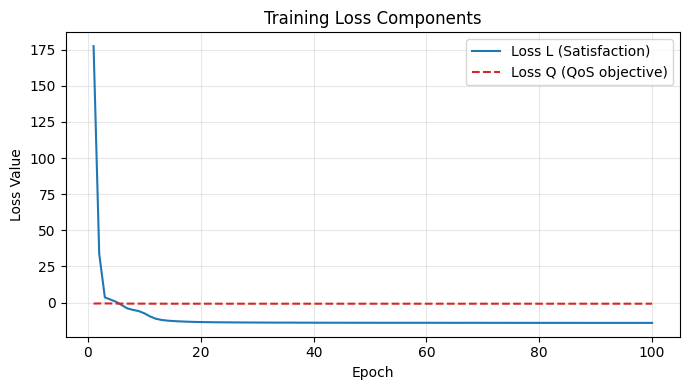

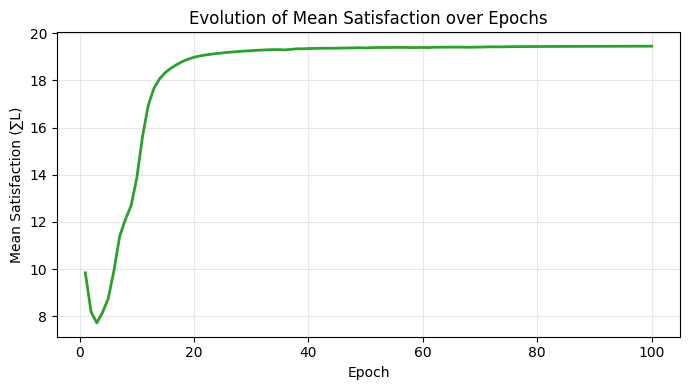

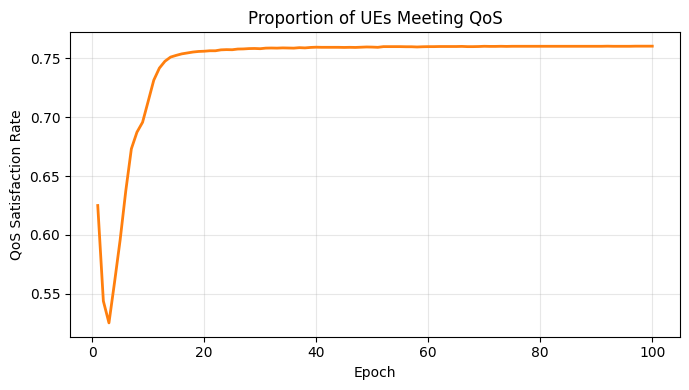

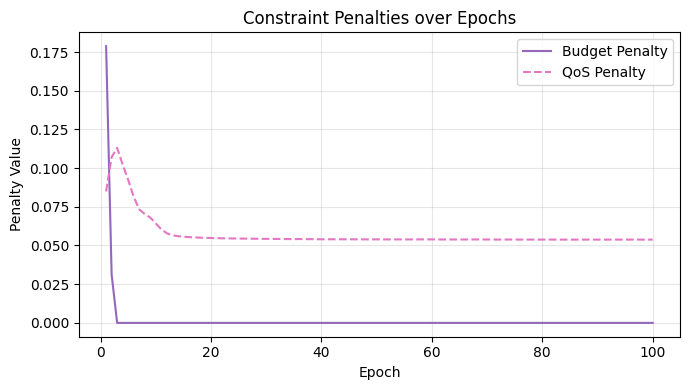

In [335]:
df_logs = pd.DataFrame(logs)
x = range(1, len(df_logs) + 1)

# ===== 1) Total Loss (L + Q) =====
plt.figure(figsize=(7, 4))
plt.plot(x, df_logs["loss_L"], label="Loss L (Satisfaction)", color='tab:blue')
plt.plot(x, df_logs["loss_Q"], label="Loss Q (QoS objective)", color='tab:red', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Training Loss Components")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 2) Satisfaction (sumL) =====
plt.figure(figsize=(7, 4))
plt.plot(x, df_logs["sumL"], color='tab:green', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Mean Satisfaction (∑L)")
plt.title("Evolution of Mean Satisfaction over Epochs")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 3) QoS Satisfaction Rate =====
plt.figure(figsize=(7, 4))
plt.plot(x, df_logs["Q_rate"], color='tab:orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("QoS Satisfaction Rate")
plt.title("Proportion of UEs Meeting QoS")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 4) Constraint Penalties =====
plt.figure(figsize=(7, 4))
plt.plot(x, df_logs["pen_budget"], label="Budget Penalty", color='tab:purple')
plt.plot(x, df_logs["pen_qos"], label="QoS Penalty", color='tab:pink', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Penalty Value")
plt.title("Constraint Penalties over Epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [63]:
# import os
# import pandas as pd

# save_dir = "congest/result1"
# os.makedirs(save_dir, exist_ok=True)
# csv_path = os.path.join(save_dir, "train_logs.csv")
# pkl_path = os.path.join(save_dir, "train_logs.pkl")

# df_logs.to_csv(csv_path, index=False)
# df_logs.to_pickle(pkl_path)

# print(f"[✓] Training logs saved to:\n  {csv_path}\n  {pkl_path}")


In [64]:
# import pandas as pd
# import matplotlib.pyplot as plt

# df_logs = pd.read_csv("congest/result1/train_logs.csv")

# plt.figure()
# plt.plot(df_logs["epoch"], df_logs["loss"])
# plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.show()

In [24]:
@torch.no_grad()
def count_violations_on_loader(policy, loader, threshold=1e-6, eps=1e-30):
    policy.eval()
    if not isinstance(loader, list):
        loader = list(loader)

    def _to_tensor(x, device, dtype=torch.float32):
        if isinstance(x, torch.Tensor):
            return x.to(device=device, dtype=dtype)
        if hasattr(x, "values"): 
            x = x.values
        return torch.tensor(x, device=device, dtype=dtype)

    users = 0
    budget_cnt = 0
    qos_cnt = 0
    any_cnt = 0
    both_cnt = 0
    scen_with_any = 0
    batches = 0

    for batch, aux_list in loader:
        device = next(policy.parameters()).device
        batch = batch.to(device)
        w_rx_all, p_f_all, a_all = policy(batch)
        user_batch = batch["user"].batch          
        gids = torch.unique_consecutive(user_batch)
        assert len(gids) == len(aux_list), "aux_list không khớp số scenario trong batch (hetero)."

        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx = w_rx_all[mask] 
            p_f  = p_f_all[mask]  
            a    = a_all[mask]    
            aux_i = aux_list[s_idx]
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in aux_i.items()}
            g_iL = aux_i.get("g_iL", aux_i.get("h_iL"))     
            g_ik = aux_i.get("g_ik", aux_i.get("h_ik"))    
            Pmax = aux_i.get("Pmax", aux_i.get("Pmax_users"))
            Ci   = aux_i.get("Ci", None)
            Lthr = aux_i.get("Lthr", None)

            noise = aux_i["noise"].squeeze()
            SL = aux_i["SL"].squeeze()
            SW = aux_i["SW"].squeeze()
            cprice = aux_i["cprice"].squeeze()

            # ép kiểu
            g_iL = _to_tensor(g_iL, device)
            g_ik = _to_tensor(g_ik, device)
            Pmax = _to_tensor(Pmax, device)
            Ci   = _to_tensor(Ci,   device)
            Lthr = _to_tensor(Lthr, device)
            wL = w_rx[:, 0]
            wW = w_rx[:, 1:]
            h_des = wL * g_iL + (wW * g_ik).sum(dim=1)  
            term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)          
            term2 = wW @ g_ik.transpose(0,1)               
            Hbar  = term1 + term2
            Hbar  = Hbar - torch.diag_embed(torch.diag(Hbar))
            P   = a * Pmax
            num = P * h_des
            SINR = torch.zeros_like(num)
            Fbands = p_f.size(1)
            for f in range(Fbands):
                S_f = p_f[:, f] * P
                denom = Hbar @ S_f + noise
                SINR += p_f[:, f] * (num / (denom + eps))

            rate = torch.log2(1.0 + SINR)
            S_i  = SW + (SL - SW) * wL
            L_i  = S_i * rate

            # masks
            budget_mask = (cprice * rate * wL - Ci) > threshold
            qos_mask    = (Lthr - L_i) > 0
            any_mask    = budget_mask | qos_mask
            both_mask   = budget_mask & qos_mask

            n_i   = int(rate.numel())
            b_i   = int(budget_mask.sum().item())
            q_i   = int(qos_mask.sum().item())
            any_i = int(any_mask.sum().item())
            both_i= int(both_mask.sum().item())

            users      += n_i
            budget_cnt += b_i
            qos_cnt    += q_i
            any_cnt    += any_i
            both_cnt   += both_i
            if any_i > 0:
                scen_with_any += 1

        

        batches += 1

    return {
        "users": users,
        "budget_violations": budget_cnt,
        "qos_violations": qos_cnt,
        "any_violations": any_cnt,
        "both_violations": both_cnt,
        "scenarios_with_any_violation": scen_with_any,
        "budget_rate": budget_cnt / max(users, 1),
        "qos_rate": qos_cnt / max(users, 1),
        "any_rate": any_cnt / max(users, 1),
        "both_rate": both_cnt / max(users, 1),
        "batches": batches,
    }

In [25]:
summary = count_violations_on_loader(model, batches)
print(summary)

{'users': 30000, 'budget_violations': 4971, 'qos_violations': 9518, 'any_violations': 12267, 'both_violations': 2222, 'scenarios_with_any_violation': 1999, 'budget_rate': 0.1657, 'qos_rate': 0.31726666666666664, 'any_rate': 0.4089, 'both_rate': 0.07406666666666667, 'batches': 32}


# Thedual-objectiveproblem

In [26]:
import math
from typing import Iterable, List, Optional
import torch
from torch.optim import Optimizer

class MTAdam(Optimizer):
    def __init__(
        self,
        params: Iterable[torch.nn.Parameter],
        lr: float = 1e-3,
        betas=(0.9, 0.999, 0.9),   # (beta1, beta2, beta3)
        eps: float = 1e-8,
        weight_decay: float = 0.0, # L2 (không decoupled) để khớp bản gốc
        amsgrad: bool = False,
        num_terms: Optional[int] = None,
    ):
        if num_terms is None or num_terms <= 0:
            raise ValueError("MTAdam: num_terms (số loss) phải > 0")
        b1, b2, b3 = betas
        if not (0.0 < b1 < 1.0 and 0.0 < b2 < 1.0 and 0.0 < b3 < 1.0):
            raise ValueError("MTAdam: betas phải nằm trong (0,1)")
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        num_terms=num_terms)
        super().__init__(params, defaults)

        # Khởi tạo state
        for group in self.param_groups:
            I = group['num_terms']
            for p in group['params']:
                if not p.requires_grad:
                    continue
                state = self.state[p]
                state['step'] = 0
                # m_i, v_i, vhat_max (AMSGrad)
                state['exp_avg']    = [torch.zeros_like(p.data) for _ in range(I)]
                state['exp_avg_sq'] = [torch.zeros_like(p.data) for _ in range(I)]
                if amsgrad:
                    state['max_exp_avg_sq'] = [torch.zeros_like(p.data) for _ in range(I)]
                # n_i: EMA(||g||) per-loss (scalar per-param)
                # dùng tensor trên cùng device với p
                state['n_mag'] = [p.data.new_tensor(1.0) for _ in range(I)]

    @torch.no_grad()
    def step_from_losses(self, losses: List[torch.Tensor], ranks: Optional[List[float]] = None, retain_graph: bool = False):
        if len(self.param_groups) == 0:
            return
        group = self.param_groups[0]
        I = group['num_terms']
        if I != len(losses):
            raise ValueError(f"MTAdam: num_terms={I} nhưng nhận {len(losses)} losses")
        if ranks is None:
            ranks = [1.0] * I

        lr = group['lr']
        beta1, beta2, beta3 = group['betas']
        eps = group['eps']
        wd = group['weight_decay']
        amsgrad = group['amsgrad']

        # Gom params (theo thứ tự cố định)
        params: List[torch.nn.Parameter] = []
        for g in self.param_groups:
            for p in g['params']:
                if p.requires_grad:
                    params.append(p)
        if not params:
            return
        grads_per_loss: List[List[Optional[torch.Tensor]]] = []
        for i, Li in enumerate(losses):
            grads_i = torch.autograd.grad(
                Li, params, retain_graph=True if (retain_graph or i < len(losses)-1) else False,
                allow_unused=True, create_graph=False
            )
            grads_per_loss.append(list(grads_i))

        # Cập nhật từng param
        for p_idx, p in enumerate(params):
            state = self.state[p]
            state['step'] += 1
            t = state['step']

            # 1) Cập nhật n_i = EMA(||g||) và tìm anchor (loss đầu tiên có norm>0)
            n_vals = []
            nonzero_first = None
            for i in range(I):
                gi = grads_per_loss[i][p_idx]
                if gi is None:
                    n_vals.append(state['n_mag'][i])
                    continue
                norm_i = torch.linalg.vector_norm(gi.detach())
                state['n_mag'][i] = beta3 * state['n_mag'][i] + (1.0 - beta3) * norm_i
                n_vals.append(state['n_mag'][i])
                if (nonzero_first is None) and (norm_i > 1e-12):
                    nonzero_first = i
            # chọn anchor
            anchor = 0 if nonzero_first is None else nonzero_first
            n_anchor = n_vals[anchor] + 1e-32

            # 2) Chuẩn hoá & scale theo ranks
            scaled_grads = []
            for i in range(I):
                gi = grads_per_loss[i][p_idx]
                if gi is None:
                    scaled_grads.append(None)
                else:
                    denom = n_vals[i] + 1e-32
                    scaled_grads.append(ranks[i] * (n_anchor / denom) * gi)

            # 3) Moments cho từng loss (m_i, v_i) + bias-correct riêng
            m_hats, v_hats, step_sizes, denoms_i = [], [], [], []
            for i in range(I):
                gi = scaled_grads[i]
                m = state['exp_avg'][i]
                v = state['exp_avg_sq'][i]
                if gi is not None:
                    if wd != 0.0:
                        gi = gi.add(p.data, alpha=wd)
                    m.mul_(beta1).add_(gi, alpha=1.0 - beta1)
                    v.mul_(beta2).addcmul_(gi, gi, value=1.0 - beta2)

                # bias-correct
                m_hat = m / (1.0 - beta1**t)
                v_hat = v / (1.0 - beta2**t)
                if amsgrad:
                    vmax = state['max_exp_avg_sq'][i]
                    torch.maximum(vmax, v_hat, out=vmax)
                    v_hat = vmax  # dùng max cho AMSGrad

                # giữ lại để kết hợp ở cuối
                m_hats.append(m_hat)
                v_hats.append(v_hat)
                step_sizes.append(lr / (1.0 - beta1**t))

                state['exp_avg'][i] = m
                state['exp_avg_sq'][i] = v

            # 4) denom chung = sqrt(max_i vhat_i) + eps
            vhat_stack = torch.stack(v_hats, dim=0)
            denom_common = torch.sqrt(torch.amax(vhat_stack, dim=0)) + eps

            # 5) tổng hợp update = sum_i ( step_size_i * mhat_i / denom_common )
            update = torch.zeros_like(p.data)
            for i in range(I):
                update.add_(m_hats[i] / denom_common, alpha=step_sizes[i])

            # 6) apply
            p.data.add_(update, alpha=-1.0)

    # tiện alias
    step_with_multitask_grads = step_from_losses


In [27]:
import torch
import torch.nn.functional as F

def compute_per_scenario_metrics(w_rx, p_f, a, aux, tau: float = 0.2,
                                 threshold: float = 1e-5):
    # ===== Unpack =====
    g_iL = aux["g_iL"]        # (N,)
    g_ik = aux["g_ik"]        # (N,K)
    Pmax = aux["Pmax"]        # (N,)
    Ci   = aux["Ci"]          # (N,)
    Lthr = aux["Lthr"]        # (N,)
    noise= aux["noise"]       # scalar
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]

    device = w_rx.device
    N, K = g_ik.size(0), g_ik.size(1)
    Fs = p_f.size(1)

    # ===== Chọn server & subband (hard one-hot từ logits / probs) =====
    s_idx = torch.argmax(w_rx, dim=1)                     # (N,)
    X = F.one_hot(s_idx, num_classes=K+1).float()         # (N, K+1)
    sc_idx = torch.argmax(p_f, dim=1)                     # (N,)
    Psi = F.one_hot(sc_idx, num_classes=Fs).float()       # (N, Fs)

    # ===== Ma trận kênh theo thứ tự [LTE | AP_1..AP_K] =====
    H = torch.cat([g_iL.unsqueeze(1), g_ik], dim=1)       # (N, K+1)

    # ===== Desired signal & tổng công suất–kênh =====
    P = a * Pmax                                          # (N,)
    SigAll = P.unsqueeze(1) * H                           # (N, K+1)
    DS = (SigAll * X).sum(dim=1)                          # (N,)

    # ===== Overlap theo subband (loại self) =====
    M = Psi @ Psi.t()                                     # (N, N)
    M.fill_diagonal_(0.0)

    S_sel = X                                             # (N, K+1)
    V = SigAll @ S_sel.t()                        
    Interf = (V * M).sum(dim=0) + noise                   # (N,)
    denom = Interf
    SINR  = DS / denom

    # ===== Rate & Satisfaction =====
    rate = torch.log2(1.0 + SINR)                         # (N,)
    # Dịch vụ theo LTE(1) / WiFi(0): wL = xác suất LTE
    wL = w_rx[:, 0]
    S_i = SW + (SL - SW) * wL
    L_i = S_i * rate

    # ===== Penalties & Q metrics =====
    penB = F.relu(cprice * rate * wL - Ci - threshold).mean()
    penQ = F.relu(Lthr - L_i).mean()
    Q_soft_mean = torch.sigmoid((L_i - Lthr) / tau).mean()
    Q_hard_cnt = int((L_i >= Lthr).sum().item())
    N_i = int(L_i.numel())

    return L_i, Q_soft_mean, Q_hard_cnt, N_i, penB, penQ


In [28]:
def one_hot_hard(prob: torch.Tensor) -> torch.Tensor:
    """Argmax -> one-hot (không gradient)."""
    idx = prob.argmax(dim=1)
    return F.one_hot(idx, num_classes=prob.size(1)).to(prob.dtype)

def one_hot_st(prob: torch.Tensor) -> torch.Tensor:
    """Straight-through: forward = one-hot, backward = prob."""
    hard = one_hot_hard(prob)
    return prob + (hard - prob).detach()

@torch.no_grad()
def _eval_rounded(w_rx, p_f, a, aux, tau=0.2):
    """Tính Q_hard_rate và sumL trên phiên bản rounded (one-hot)."""
    w_rx_h = one_hot_hard(w_rx)
    p_f_h  = one_hot_hard(p_f)
    L_i, Q_soft_mean, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
        w_rx_h, p_f_h, a, aux, tau=tau
    )
    sumL = L_i.sum()
    Q_hard_rate = float(Q_hard_cnt)
    return sumL, Q_hard_rate

def train_dual_MTAdam(
    policy: torch.nn.Module,
    batches,                     
    mtadam,                        
    lambda_budget: float = 1.0,
    lambda_qos: float = 1.0,
    tau: float = 0.2,
):
    device = next(policy.parameters()).device
    policy.train()

    ep_lossL = ep_lossQ = 0.0
    ep_sumL  = ep_Qrate = 0.0
    ep_penB  = ep_penQ  = 0.0

    # ep_sumL_test = 0.0
    # ep_Q_test    = 0.0

    num_batches = 0

    for batch, aux_list in batches:
        batch = batch.to(device)
        w_rx_all, p_f_all, a_all = policy(batch)         
        user_batch = batch["user"].batch             
        gids = torch.unique_consecutive(user_batch)    
        if len(gids) != len(aux_list):
            continue

        L_all, Qsoft_list = [], []
        penB_list, penQ_list = [], []
        hard_total, users_total = 0, 0

        # sumL_test_batch = 0.0
        # Q_rate_test = 0.0
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            if mask.sum() == 0:
                continue

            w_rx = w_rx_all[mask]
            p_f  = p_f_all[mask]
            a    = a_all[mask]
            # print(a)

            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in aux_list[s_idx].items()}

            L_i, Q_soft_mean, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=tau
            )
            if L_i.numel() == 0:
                continue
            # print(a.all() == 1)
            L_all.append(L_i)
            Qsoft_list.append(Q_soft_mean)
            penB_list.append(penB)
            penQ_list.append(penQ)
            hard_total  += Q_hard_cnt
            users_total += N_i

            # sumL_r, Qr = _eval_rounded(w_rx, p_f, a, aux_i, tau=tau)
            # sumL_test_batch += float(sumL_r.item())
            # Q_rate_test += Qr
            # p_f_h  = one_hot_hard(p_f)
            # print(p_f_h)


        if len(L_all) == 0:
            continue
        sumL       = torch.stack([L.sum() for L in L_all]).mean()
        Q_soft     = torch.stack(Qsoft_list).mean()
        Q_hard_rate= hard_total / users_total
        pen_budget = torch.stack(penB_list).mean()
        pen_qos    = torch.stack(penQ_list).mean()

        loss_L = -sumL + lambda_budget * pen_budget + lambda_qos * pen_qos
        loss_Q = -Q_soft
        mtadam.step_from_losses([loss_L, loss_Q])

        # batch test metrics (rounded)
        # sumL_test = sumL_test_batch / max(len(gids), 1)
        # Q_test    = Q_rate_test / max(users_total, 1)

        ep_lossL += float(loss_L.item())
        ep_lossQ += float(loss_Q.item())
        ep_sumL  += float(sumL.item())
        ep_Qrate += float(Q_hard_rate)
        ep_penB  += float(pen_budget.item())
        ep_penQ  += float(pen_qos.item())

        # ep_sumL_test  += float(sumL_test)
        # ep_Q_test     += float(Q_test)

        num_batches += 1

    return {
        "loss_L":   ep_lossL / max(num_batches, 1),
        "loss_Q":   ep_lossQ / max(num_batches, 1),
        "sumL":     ep_sumL / max(num_batches, 1),
        "Q_rate":   ep_Qrate / max(num_batches, 1),
        "pen_budget": ep_penB / max(num_batches, 1),
        "pen_qos":    ep_penQ / max(num_batches, 1),

        # "sumL_test":  ep_sumL_test  / max(num_batches, 1),
        # "Q_test":     ep_Q_test     / max(num_batches, 1),
        
        "batches":  num_batches,
    }


In [29]:
# -*- coding: utf-8 -*-
import os, math, h5py, numpy as np, torch
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader

# =======================
# Helpers (HDF5 / MATLAB v7.3)
# =======================
def _h5_scalar(f, key):
    if key not in f: 
        raise KeyError(f"Missing scalar '{key}' in file.")
    return float(np.array(f[key]).squeeze())

def _runs_len(runs_group):
    # Xác định số phần tử struct-array 'runs' dùng một field "ổn định"
    for k in ["H", "Ci", "Lthr"]:
        if k in runs_group:
            ds = runs_group[k]
            shp = ds.shape
            if len(shp) == 2:
                return shp[1] if shp[0] == 1 else shp[0]
            return shp[0]
    raise KeyError("Cannot infer runs length; 'runs' missing expected fields.")

def _get_field_from_runs(f, runs_group, field, idx):
    if field not in runs_group: 
        raise KeyError(f"runs.{field} is missing.")
    ds = runs_group[field]
    arr = ds[()]  # array of obj refs
    ref = arr[0, idx] if (arr.ndim == 2 and arr.shape[0] == 1) else \
          (arr[idx, 0] if (arr.ndim == 2 and arr.shape[1] == 1) else arr[idx])
    return np.array(f[ref])

def pathloss_db_from_d(d_m: float) -> float:
    d_eff = max(float(d_m), 1.0)            # tránh log10(0)
    d_km  = d_eff / 1000.0
    base  = -(120.9 + 37.6 * math.log10(d_km))
    noise = 7.0 * np.random.randn()         # ~ N(0, 7^2) dB
    return base + noise

# =======================
# Build graph từ 1 scenario
# =======================
def build_bipartite_from_H(
    H, d_u_ap, d_u_bs, Pmax_scalar, Ci_vec, Lthr_vec, n0_scalar,
    Fs: int,
    standardize_user: bool = True,
    standardize_edge: bool = False
):
    """
    H: (U, K+1) — cột cuối là BS; d_u_ap: (U, K); d_u_bs: (U,)
    Edge_attr = [gain, pathloss_dB, link_type, noise]
    Thêm meta.fs để dùng band-head động.
    """
    H = np.array(H, dtype=np.float32); U, Kp1 = H.shape; K = Kp1 - 1
    d_u_ap = np.array(d_u_ap, dtype=np.float32).reshape(U, K)
    d_u_bs = np.array(d_u_bs, dtype=np.float32).reshape(U)
    Ci  = np.array(Ci_vec,  dtype=np.float32).reshape(U)
    Lthr= np.array(Lthr_vec,dtype=np.float32).reshape(U)
    Pmax_vec = np.full((U,), float(Pmax_scalar), dtype=np.float32)
    n0 = float(n0_scalar)

    # --- User features ---
    user_x = np.stack([ Ci, Lthr, Pmax_vec], axis=1).astype(np.float32)
    if standardize_user:
        mu, sd = user_x.mean(axis=0), user_x.std(axis=0); sd[sd == 0] = 1.0
        user_x = (user_x - mu) / sd

    data = HeteroData()
    data["user"].x = torch.tensor(user_x, dtype=torch.float32)

    # --- Infra features (K AP + 1 BS; cột 0 là BS trong graph) ---
    infra_x = np.zeros((K+1, 1), dtype=np.float32)
    infra_x[0, 0] = 1.0  # mark BS
    data["infra"].x = torch.tensor(infra_x, dtype=torch.float32)

    # --- Edges & attributes ---
    edge_src, edge_dst, edge_attr = [], [], []

    # user->BS (index 0)
    for i in range(U):
        gain = float(H[i, -1])
        pl   = pathloss_db_from_d(d_u_bs[i])
        edge_src.append(i); edge_dst.append(0)
        edge_attr.append([d_u_bs[i], gain, pl, 1.0])

    # user->APs (index 1..K)
    for i in range(U):
        for k in range(K):
            gain = float(H[i, k])
            pl   = pathloss_db_from_d(d_u_ap[i, k])
            edge_src.append(i); edge_dst.append(1 + k)
            edge_attr.append([d_u_bs[i], gain, pl, 0.0])

    edge_attr = torch.tensor(edge_attr, dtype=torch.float32)
    if standardize_edge:
        mean = edge_attr.mean(dim=0, keepdim=True)
        std  = edge_attr.std(dim=0, keepdim=True); std[std == 0] = 1.0
        edge_attr = (edge_attr - mean) / std

    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    data["user", "link", "infra"].edge_index = edge_index
    data["user", "link", "infra"].edge_attr  = edge_attr
    data["infra", "rev_link", "user"].edge_index = edge_index.flip(0)
    data["infra", "rev_link", "user"].edge_attr  = edge_attr

    # meta: Fs cho mỗi graph (khi batch sẽ concat thành vector)
    data["meta"].fs = torch.tensor([int(Fs)], dtype=torch.long)

    # --- Aux cho loss/tính metric ---
    aux = {
        "g_iL":   torch.tensor(H[:, -1], dtype=torch.float32),
        "g_ik":   torch.tensor(H[:, :K], dtype=torch.float32),
        "Pmax":   torch.full((U,), float(Pmax_scalar), dtype=torch.float32),
        "Ci":     torch.tensor(Ci,   dtype=torch.float32),
        "Lthr":   torch.tensor(Lthr, dtype=torch.float32),
        "noise":  torch.tensor(n0,   dtype=torch.float32),
        "SL": None,  # sẽ thêm khi đọc file (S_l)
        "SW": None,  # sẽ thêm khi đọc file (S_w)
        "cprice": None, # sẽ thêm khi đọc file (c)
        "N": U, "K": K, "Fs": int(Fs),
    }
    return data, aux

# =======================
# Build batches từ .mat
# =======================
def build_batches_from_matlab(
    mat_path: str,
    batch_size: int = 64,
    device: torch.device | None = None,
    standardize_user: bool = True,
    standardize_edge: bool = True,
):
    """
    Đọc file .mat (v7.3) từ MATLAB script đã sửa và build thành 
    [(batched_graph, aux_list)] cho training.
    Yêu cầu trong 'runs(n)': H, d_u_ap, d_u_bs, Ci, Lthr, S (subbands).
    """
    assert os.path.isfile(mat_path), f"Not found: {mat_path}"
    graphs, auxes = [], []

    with h5py.File(mat_path, "r") as f:
        # scalars chung
        n0     = _h5_scalar(f, "n0")
        S_l    = _h5_scalar(f, "S_l")
        S_w    = _h5_scalar(f, "S_w")
        cprice = _h5_scalar(f, "c")
        P_max  = _h5_scalar(f, "P_max")

        runs = f["runs"]
        R = _runs_len(runs)

        for i in range(R):
            H     = _get_field_from_runs(f, runs, "H",      i).T
            d_ap  = _get_field_from_runs(f, runs, "d_u_ap", i).T
            d_bs  = _get_field_from_runs(f, runs, "d_u_bs", i).T
            Ci    = _get_field_from_runs(f, runs, "Ci",     i).T
            Lthr  = _get_field_from_runs(f, runs, "Lthr",   i).T

            # S (số subbands) có thể lưu dạng scalar hoặc vector (1x1)
            if "S" in runs:
                S_val = _get_field_from_runs(f, runs, "S", i).squeeze()
                Fs = int(np.array(S_val).item())
            else:
                # fallback (nếu chưa lưu): bạn có thể đặt giá trị mặc định
                Fs = 5

            data_i, aux_i = build_bipartite_from_H(
                H, d_ap, d_bs, P_max, Ci, Lthr, n0, Fs,
                standardize_user=standardize_user,
                standardize_edge=standardize_edge
            )
            # thêm các scalar chung
            aux_i["SL"]     = torch.tensor(S_l,    dtype=torch.float32)
            aux_i["SW"]     = torch.tensor(S_w,    dtype=torch.float32)
            aux_i["cprice"] = torch.tensor(cprice, dtype=torch.float32)

            if device is not None:
                data_i = data_i.to(device)

            graphs.append(data_i)
            auxes.append(aux_i)

    # DataLoader của PyG sẽ tự ghép batch và tạo .batch cho từng node-type
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=True)
    batches = []
    # Để align aux theo batch (không shuffle lại lần 2)
    idx = 0
    for batched in loader:
        # số graph trong batch hiện tại:
        G = batched.num_graphs
        aux_list = []
        for j in range(G):
            aux_j = {k: (v.clone().to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in auxes[idx + j].items()}
            aux_list.append(aux_j)
        idx += G

        if device is not None:
            batched = batched.to(device)

        batches.append((batched, aux_list))
    return batches


## model mtadam

In [326]:
policy = PolicyHetero(
    user_in=3,
    infra_in=1,
    hidden=512,
    Fs = 5
)
mtadam = MTAdam(policy.parameters(), lr=1e-4, weight_decay=1e-3,
                num_terms=2, 
                betas=(0.9, 0.9, 0.75)) 

scheduler_mt = torch.optim.lr_scheduler.StepLR(mtadam, step_size=20, gamma=0.7)

In [240]:
for batch, aux_list in batches:
        batch = batch.to(device)
        w_rx_all, p_f_all, a_all = policy(batch)         
        user_batch = batch["user"].batch             
        gids = torch.unique_consecutive(user_batch)    
        if len(gids) != len(aux_list):
            continue

        L_all, Qsoft_list = [], []
        penB_list, penQ_list = [], []
        hard_total, users_total = 0, 0

        sumL_test_batch = 0.0
        Q_rate_test = 0.0
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            if mask.sum() == 0:
                continue

            w_rx = w_rx_all[mask]
            p_f  = p_f_all[mask]
            a    = a_all[mask]
            # print(a)

            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in aux_list[s_idx].items()}

            L_i, Q_soft_mean, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=0.2
            )
            p_f_h  = one_hot_hard(p_f)
            print(p_f_h)
      

tensor([[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])
tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [

## data

In [362]:
cfg = SimCfg(R=200, P_max=200, S_L=1.0, S_W=0.75, c_price=0.1, B=10**6, n0=None, Fs=5, K=5, N=10, select_u=0.3, L_thr=1.0)
batches = build_fixed_batches_bipartite(cfg, num_scenarios=2000, batch_size=64, start_seed=37, standardize = True)
print(f"Số batch cố định: {len(batches)}")

Số batch cố định: 32


In [33]:
# mat_path = "congest/data/15_5.mat"

# batches = build_batches_from_matlab(mat_path=mat_path, batch_size=64,device=device)

In [34]:
from dataclasses import replace
import torch
from torch_geometric.loader import DataLoader

def build_mixed_batches_bipartite(
    cfg_base,
    Ns=(10, 15, 20, 25, 30),
    num_scenarios_each=200,
    batch_size=64,
    start_seed=37,
    standardize=True,
    device=None,
):
    """
    Trả về: list[(batched_graph, aux_list)] để train.
    Yêu cầu: cfg_base.K, cfg_base.Fs, các tham số khác (trừ N) giữ nguyên.
    """
    data_list_all = []
    aux_list_all  = []
    seed = start_seed

    for N in Ns:
        cfg_i = replace(cfg_base, N=N)  # chỉ thay đổi N
        for _ in range(num_scenarios_each):
            df_i, data_i, aux_i = generate_dataset_bipartite(
                cfg_i, seed=seed, standardize=standardize
            )
            seed += 1

            # (tuỳ code model bạn) nếu cần lưu Fs để head subband đọc theo từng graph:
            # data_i["meta"].fs = torch.tensor([cfg_i.Fs], dtype=torch.long)

            if device is not None:
                data_i = data_i.to(device)

            data_list_all.append(data_i)
            aux_list_all.append(aux_i)

    # Gom các đồ thị kích thước khác nhau thành batch
    loader = DataLoader(data_list_all, batch_size=batch_size, shuffle=True)

    batches = []
    cursor = 0
    for batched in loader:
        # batch này chứa `batched.num_graphs` đồ thị
        gcount = int(batched.num_graphs)
        aux_slice = aux_list_all[cursor: cursor + gcount]
        cursor += gcount

        # nếu cần trên GPU
        if device is not None:
            batched = batched.to(device)

        # đảm bảo có .batch cho mỗi type
        # (PyG DataLoader sẽ tự thêm; đoạn dưới chỉ phòng trường hợp bạn cần)
        # if not hasattr(batched["user"], "batch"):
        #     batched["user"].batch = torch.zeros(batched["user"].num_nodes, dtype=torch.long, device=batched["user"].x.device)
        # if not hasattr(batched["infra"], "batch"):
        #     batched["infra"].batch = torch.zeros(batched["infra"].num_nodes, dtype=torch.long, device=batched["infra"].x.device)

        batches.append((batched, aux_slice))

    return batches


In [361]:
cfg_base = SimCfg(R=200, P_max=200, S_L=1.0, S_W=0.75, c_price=0.1,
                  B=10**6, n0=None, Fs=5, K=5, N=10, select_u=0.3, L_thr=1.0)

device = next(model.parameters()).device
mixed_batches = build_mixed_batches_bipartite(
    cfg_base,
    Ns=tuple(range(10, 31, 5)),        # 10,15,20,25,30
    num_scenarios_each=200,
    batch_size=64,
    start_seed=37,
    standardize=True,
    device=device
)


## training

In [363]:
mt_logs = []
EPOCHS = 100
for ep in range(1, EPOCHS+1):
    ep_log = train_dual_MTAdam(
        policy, batches, mtadam,
        lambda_budget=1000.0, lambda_qos=10.0, tau = 0.5
    )
    ep_log["epoch"] = ep
    mt_logs.append(ep_log)
    print(f"[Ep {ep:03d}] sumL_train={ep_log['sumL']:.4f} | Q_rate%={100*ep_log['Q_rate']:.2f}% "
          f"| loss_L={ep_log['loss_L']:.4f} | loss_Q={ep_log['loss_Q']:.4f} "
          f"| pen(B)={ep_log['pen_budget']:.6f} | pen(Q)={ep_log['pen_qos']:.4f}")
    scheduler_mt.step()


[Ep 001] sumL_train=21.7988 | Q_rate%=48.00% | loss_L=-15.7588 | loss_Q=-0.5365 | pen(B)=0.002009 | pen(Q)=0.4031
[Ep 002] sumL_train=24.0979 | Q_rate%=50.59% | loss_L=-18.2732 | loss_Q=-0.5574 | pen(B)=0.001997 | pen(Q)=0.3827
[Ep 003] sumL_train=24.5606 | Q_rate%=50.96% | loss_L=-18.7684 | loss_Q=-0.5611 | pen(B)=0.001997 | pen(Q)=0.3795
[Ep 004] sumL_train=25.1580 | Q_rate%=51.58% | loss_L=-19.4157 | loss_Q=-0.5664 | pen(B)=0.001997 | pen(Q)=0.3745
[Ep 005] sumL_train=25.7840 | Q_rate%=52.09% | loss_L=-20.0854 | loss_Q=-0.5710 | pen(B)=0.001997 | pen(Q)=0.3701
[Ep 006] sumL_train=26.2109 | Q_rate%=52.54% | loss_L=-20.5437 | loss_Q=-0.5746 | pen(B)=0.001997 | pen(Q)=0.3670
[Ep 007] sumL_train=26.5138 | Q_rate%=52.86% | loss_L=-20.8678 | loss_Q=-0.5771 | pen(B)=0.001997 | pen(Q)=0.3649
[Ep 008] sumL_train=26.6011 | Q_rate%=52.90% | loss_L=-20.9641 | loss_Q=-0.5774 | pen(B)=0.001997 | pen(Q)=0.3640
[Ep 009] sumL_train=26.6945 | Q_rate%=52.96% | loss_L=-21.0584 | loss_Q=-0.5778 | pen(B)

## Convergence

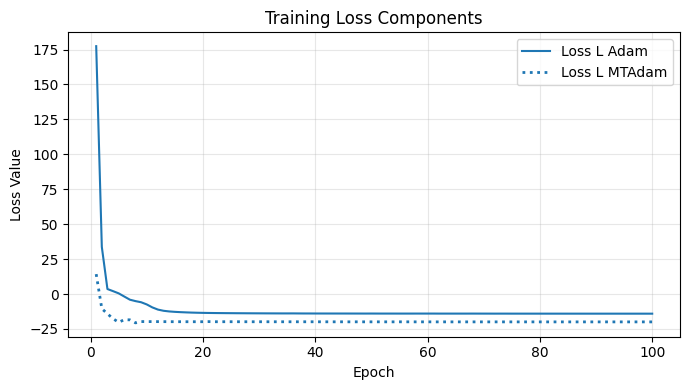

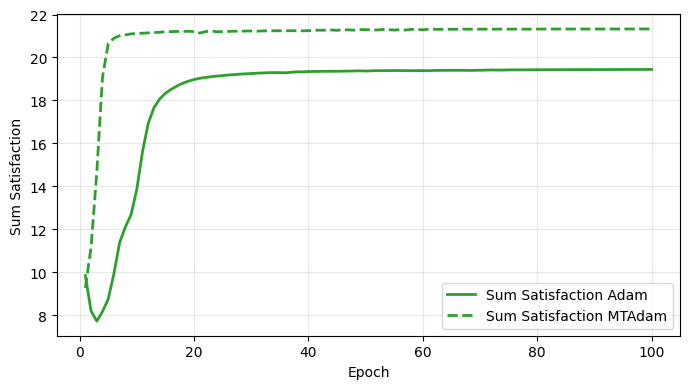

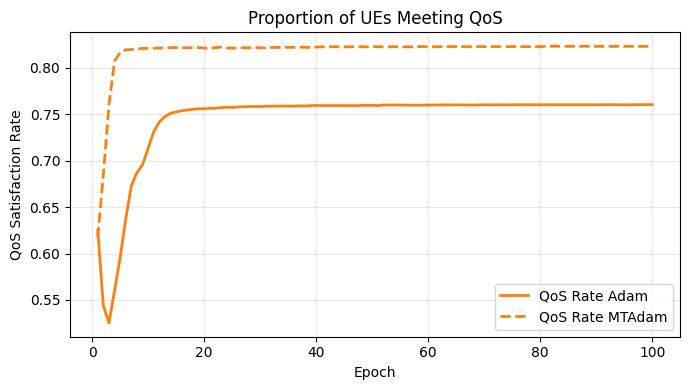

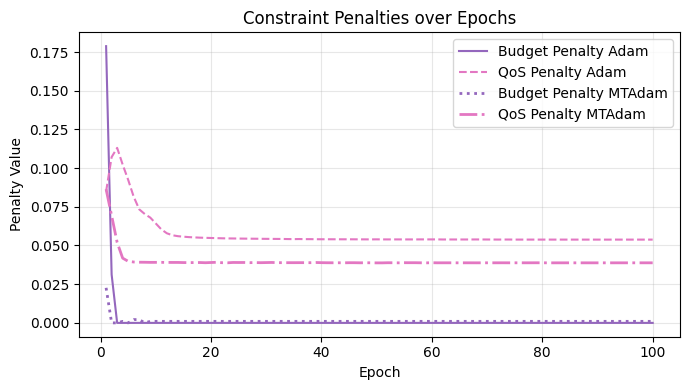

In [345]:
import matplotlib.pyplot as plt
import pandas as pd

df_logs = pd.DataFrame(logs)
mt_logs = pd.DataFrame(mt_logs)

x = range(1, len(df_logs) + 1)

def maybe_plot(ax, x, df, col, label, style_kwargs):
    if col in df.columns and len(df) > 0:
        ax.plot(x, df[col], label=label, **style_kwargs)

plt.figure(figsize=(7, 4))
ax = plt.gca()
maybe_plot(ax, x, df_logs, "loss_L", "Loss L Adam", dict(color='tab:blue'))
# maybe_plot(ax, x, df_logs, "loss_Q", "Loss Q Adam", dict(color='tab:red', linestyle='--'))

maybe_plot(ax, x, mt_logs, "loss_L", "Loss L MTAdam", dict(color='tab:blue', linestyle=':', linewidth=2))
# maybe_plot(ax, x, mt_logs, "loss_Q", "Loss Q MTAdam", dict(color='tab:red', linestyle='-.', linewidth=2))

ax.set_xlabel("Epoch"); ax.set_ylabel("Loss Value")
ax.set_title("Training Loss Components")
ax.legend(); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(7, 4))
ax = plt.gca()
maybe_plot(ax, x, df_logs, "sumL", "Sum Satisfaction Adam", dict(color='tab:green', linewidth=2))
maybe_plot(ax, x, mt_logs, "sumL", "Sum Satisfaction MTAdam", dict(color='tab:green', linestyle='--', linewidth=2))

ax.set_xlabel("Epoch"); ax.set_ylabel("Sum Satisfaction")
# ax.set_title("Evolution of Mean Satisfaction over Epochs")
# plt.xticks()
ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show()

# ===== 3) QoS Satisfaction Rate =====
plt.figure(figsize=(7, 4))
ax = plt.gca()
maybe_plot(ax, x, df_logs, "Q_rate", "QoS Rate Adam", dict(color='tab:orange', linewidth=2))
maybe_plot(ax, x, mt_logs, "Q_rate", "QoS Rate MTAdam", dict(color='tab:orange', linestyle='--', linewidth=2))

ax.set_xlabel("Epoch"); ax.set_ylabel("QoS Satisfaction Rate")
ax.set_title("Proportion of UEs Meeting QoS")
ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show()

# ===== 4) Constraint Penalties =====
plt.figure(figsize=(7, 4))
ax = plt.gca()
maybe_plot(ax, x, df_logs, "pen_budget", "Budget Penalty Adam", dict(color='tab:purple'))
maybe_plot(ax, x, df_logs, "pen_qos",    "QoS Penalty Adam",    dict(color='tab:pink', linestyle='--'))

maybe_plot(ax, x, mt_logs, "pen_budget", "Budget Penalty MTAdam", dict(color='tab:purple', linestyle=':', linewidth=2))
maybe_plot(ax, x, mt_logs, "pen_qos",    "QoS Penalty MTAdam",    dict(color='tab:pink', linestyle='-.', linewidth=2))

ax.set_xlabel("Epoch"); ax.set_ylabel("Penalty Value")
ax.set_title("Constraint Penalties over Epochs")
ax.legend(); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import os

save_path = "congest/convergence/train_curve_data2.npz"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(save_path,
         df_logs=df_logs.to_dict(orient="list"),
         mt_logs=mt_logs.to_dict(orient="list"))

print(f"[OK] Saved training log data to {save_path}")


[OK] Saved training log data to congest/convergence/train_curve_data.npz


In [106]:
summary2 = count_violations_on_loader(policy, batches)
print(summary2)

{'users': 30000, 'budget_violations': 4697, 'qos_violations': 10656, 'any_violations': 13255, 'both_violations': 2098, 'scenarios_with_any_violation': 2000, 'budget_rate': 0.15656666666666666, 'qos_rate': 0.3552, 'any_rate': 0.44183333333333336, 'both_rate': 0.06993333333333333, 'batches': 32}


In [ ]:
def _violation_rates_from_outputs(w_rx, p_f, a, aux, eps: float = 1e-30):
    device = w_rx.device
    g_iL  = aux["g_iL"].to(device)      # (N,)
    g_ik  = aux["g_ik"].to(device)      # (N,K)
    Pmax  = aux["Pmax"].to(device)      # (N,)
    Ci    = aux["Ci"].to(device)        # (N,)
    Lthr  = aux["Lthr"].to(device)      # (N,)
    noise = aux["noise"].to(device).squeeze()   # scalar
    SL    = aux["SL"].to(device).squeeze()
    SW    = aux["SW"].to(device).squeeze()
    cprice= aux["cprice"].to(device).squeeze()

    # ---- sizes & split LTE/AP ----
    N, Kp1 = w_rx.shape
    K = g_ik.size(1)
    F = p_f.size(1)
    assert Kp1 == K + 1, f"w_rx:{w_rx.shape} not compatible with g_ik:{g_ik.shape}"

    wL = w_rx[:, 0]      # (N,)
    wW = w_rx[:, 1:]     # (N,K)

    # ---- effective desired gain & interference kernel ----
    # desired gain (expected by soft association)
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                                # (N,)
    # pairwise interference weights
    Hbar = wL.unsqueeze(1) * g_iL.unsqueeze(0) + wW @ g_ik.transpose(0, 1)    # (N,N)
    Hbar = Hbar - torch.diag_embed(torch.diag(Hbar))                           # zero diagonal

    # ---- transmit power & SINR aggregation over subbands ----
    P = a * Pmax                                                               # (N,)
    num = P * h_des                                                            # (N,)
    SINR = torch.zeros_like(num)
    for f in range(F):
        S_f = p_f[:, f] * P                                                   # (N,)
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num / (denom + eps))                              # expectation over f

    rate = torch.log2(1.0 + SINR)                                              # (N,)

    # ---- satisfaction & violations ----
    S_i = SW + (SL - SW) * wL                                                  # (N,)
    L_i = S_i * rate                                                           # (N,)

    budget_mask = (cprice * rate * wL - Ci) > 0                                # True if violates budget
    qos_mask    = (L_i < Lthr)                                                 # True if violates QoS

    sum_L = float(L_i.sum().item())
    budget_rate = float(budget_mask.float().mean().item()) if N > 0 else 0.0
    qos_rate    = float(qos_mask.float().mean().item())    if N > 0 else 0.0

    return sum_L, budget_rate, qos_rate
MAT_PATH = "congest/data/15_5.mat"
device = next(model.parameters()).device

total_satisfied = 0
total_users = 0

policy.eval()
with torch.no_grad():
    for batched, aux_list in batches:
        w_rx_all, p_f_all, a_all = policy(batched)
        user_batch = batched["user"].batch
        gids = torch.unique_consecutive(user_batch).tolist()
        for s_idx, g in enumerate(gids):
            mask = (user_batch == g)
            w_rx = w_rx_all[mask]; p_f = p_f_all[mask]; a = a_all[mask]
            aux = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                   for k, v in aux_list[s_idx].items()}
            sumL, bud_rate, qos_rate = _violation_rates_from_outputs(w_rx, p_f, a, aux)
            N = aux["g_iL"].numel()
            satisfied = N * (1 - qos_rate)  # tỉ lệ user đạt QoS
            total_satisfied += satisfied
            total_users += N

avg_satisfied_model = total_satisfied / total_users*N

# --------------------------
# Đọc kết quả MATLAB (cột Qset_size)
# --------------------------
with h5py.File(MAT_PATH, "r") as f:
    results = np.array(f["results"])
    if results.shape[0] == 7:  # (7, N)
        results = results.T
    Qset_size = results[:, 4]   # cột thứ 5: số user đạt QoS mỗi run
    avg_satisfied_matlab = np.nanmean(Qset_size)

# --------------------------
# In kết quả
# --------------------------
print(f"Average satisfied users (Policy):  {avg_satisfied_model:.2f}")
print(f"Average satisfied users (MATLAB): {avg_satisfied_matlab:.2f}")


# Heuristic

In [ ]:
def ensure_single_graph_batch(data):
    if not hasattr(data["user"], "batch"):
        data["user"].batch = torch.zeros(data["user"].num_nodes, dtype=torch.long)
    if not hasattr(data["infra"], "batch"):
        data["infra"].batch = torch.zeros(data["infra"].num_nodes, dtype=torch.long)
    return data

In [ ]:
def greedy_assignment(C_i, K):
    X_iL = np.zeros(len(C_i), dtype=int)
    ap_idx = np.full(len(C_i), -1, dtype=int)  # -1 nếu LTE

    for i in range(len(C_i)):
        if C_i[i] > 0:
            X_iL[i] = 1
            ap_idx[i] = -1
        else:
            ap_idx[i] = random.randint(0, K-1)
            X_iL[i] = 0
    return X_iL, ap_idx


def inference_from_model(model, batches, device):
    model.eval()
    w_rx_all = []
    p_f_all = []
    a_all = []
    for batch, aux_list in batches:
        batch = batch.to(device)
        w_rx, p_f, a = model(batch.x, batch.edge_index, batch.edge_weight)
        w_rx_all.append(w_rx)
        p_f_all.append(p_f)
        a_all.append(a)

    w_rx_all = torch.cat(w_rx_all, dim = 0)
    p_f_all = torch.cat(p_f_all, dim = 0)
    a_all = torch.cat(a_all, dim = 0)

    return w_rx_all, p_f_all, a_all

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = next(model.parameters()).device

def ensure_single_graph_batch(data):
    if not hasattr(data["user"], "batch"):
        data["user"].batch = torch.zeros(data["user"].num_nodes, dtype=torch.long)
    if not hasattr(data["infra"], "batch"):
        data["infra"].batch = torch.zeros(data["infra"].num_nodes, dtype=torch.long)
    return data

num_test = 1000
start_seed = 7

X_iL_greedy_total = 0 
X_iL_model_total  = 0
X_iL_policy_total = 0

for i in range(num_test):
    seed = start_seed + i
    df_i, data_i, aux_i = generate_dataset_bipartite(cfg, seed=seed, standardize=True)

    # Greedy LTE if Ci>0 else best AP
    Ci_np = aux_i["Ci"].cpu().numpy()
    X_iL_greedy, ap_idx_greedy = greedy_assignment(Ci_np, cfg.K)  # (N,), (N,)
    X_iL_greedy_total += int(np.sum(X_iL_greedy))

    # HeteroData inference (ensure batch fields)
    data_i = ensure_single_graph_batch(data_i).to(device)

    with torch.no_grad():
        # GNN Adam
        w_rx_model, p_f_model, a_model = model(data_i)
        X_iL_model = (w_rx_model.argmax(dim=1).cpu().numpy() == 0)  # cột 0 là LTE
        X_iL_model_total += int(np.sum(X_iL_model))

        # GNN MTAdam
        w_rx_policy, p_f_policy, a_policy = policy(data_i)
        X_iL_policy = (w_rx_policy.argmax(dim=1).cpu().numpy() == 0)
        X_iL_policy_total += int(np.sum(X_iL_policy))

# Trung bình số user chọn LTE trên mỗi scenario
avg_LTE_greedy = X_iL_greedy_total / num_test
avg_LTE_model  = X_iL_model_total  / num_test
avg_LTE_policy = X_iL_policy_total / num_test

# Số user chọn AP = N - LTE
avg_AP_greedy = cfg.N - avg_LTE_greedy
avg_AP_model  = cfg.N - avg_LTE_model
avg_AP_policy = cfg.N - avg_LTE_policy

labels = ['LTE', 'AP']
x = np.arange(len(labels))
width = 0.28

greedy_vals = [avg_LTE_greedy, avg_AP_greedy]
model_vals  = [avg_LTE_model,  avg_AP_model]
policy_vals = [avg_LTE_policy, avg_AP_policy]

fig, ax = plt.subplots(figsize=(8, 5.5))
ax.bar(x - width, greedy_vals, width, label='Greedy', color='orange')
ax.bar(x,         model_vals,  width, label='GNN Adam', color='tab:blue')
ax.bar(x + width, policy_vals, width, label='GNN MTAdam', color='tab:red')

ax.set_ylabel('Avg. #Users per scenario')
ax.set_title('Average User Assignment Distribution (LTE vs AP)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt

device = next(model.parameters()).device

num_test = 1000
start_seed = 7

mean_L_model_total = mean_L_adam_total = mean_L_greedy_total = 0.0
budget_model_total = budget_adam_total = budget_greedy_total = 0.0
qos_model_total = qos_adam_total = qos_greedy_total = 0.0
Qrate_model_total = Qrate_adam_total = Qrate_greedy_total = 0.0

batches = build_fixed_batches_bipartite(cfg, num_scenarios=num_test, batch_size=1, start_seed=start_seed)

for batch, aux_list in batches:
    batch = batch.to(device)
    user_batch = batch["user"].batch
    gids = torch.unique_consecutive(user_batch)
    assert len(gids) == len(aux_list)

    # ===== 1) GNN Adam =====
    with torch.no_grad():
        w_rx_all, p_f_all, a_all = model(batch)
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx = w_rx_all[mask]
            p_f  = p_f_all[mask]
            a    = a_all[mask]
            aux_i = aux_list[s_idx]
            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=0.2
            )
            mean_L_model_total += float(L_i.sum().item())
            Qrate_model_total   += float(Q_hard_cnt) / float(N_i)
            budget_model_total  += float(penB.item())
            qos_model_total     += float(penQ.item())

    # ===== 2) GNN MTAdam =====
    with torch.no_grad():
        w_rx_all, p_f_all, a_all = policy(batch)
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx = w_rx_all[mask]
            p_f  = p_f_all[mask]
            a    = a_all[mask]
            aux_i = aux_list[s_idx]
            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=0.2
            )
            mean_L_adam_total += float(L_i.sum().item())
            Qrate_adam_total   += float(Q_hard_cnt) / float(N_i)
            budget_adam_total  += float(penB.item())
            qos_adam_total     += float(penQ.item())

    # ===== 3) Greedy baseline =====
    for s_idx, g in enumerate(gids.tolist()):
        aux_i = aux_list[s_idx]
        N, K, Fs = aux_i["N"], aux_i["K"], aux_i["F"]
        w_rx_greedy = torch.zeros((N, K + 1), dtype=torch.float32, device=device)
        p_f_greedy  = torch.zeros((N, Fs), dtype=torch.float32, device=device)
        a_greedy    = torch.ones((N,), dtype=torch.float32, device=device)
        Ci_t = aux_i["Ci"].to(device)
        lte_mask = (Ci_t > 0)
        w_rx_greedy[lte_mask, 0] = 1.0
        nonlte = (~lte_mask).nonzero(as_tuple=False).view(-1)
        if nonlte.numel() > 0:
            g_ik = aux_i["g_ik"].to(device)
            best_ap = torch.argmax(g_ik[nonlte], dim=1)
            w_rx_greedy[nonlte, 1 + best_ap] = 1.0
        subband_idx = torch.randint(0, Fs, (N,), device=device)
        p_f_greedy[torch.arange(N), subband_idx] = 1.0

        with torch.no_grad():
            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx_greedy, p_f_greedy, a_greedy, aux_i, tau=0.2
            )
            mean_L_greedy_total += float(L_i.sum().item())
            Qrate_greedy_total   += float(Q_hard_cnt) / float(N_i)
            budget_greedy_total  += float(penB.item())
            qos_greedy_total     += float(penQ.item())

# ===== Tính trung bình =====
mean_L_model_avg  = mean_L_model_total / num_test
mean_L_adam_avg   = mean_L_adam_total / num_test
mean_L_greedy_avg = mean_L_greedy_total / num_test

Qrate_model_avg  = Qrate_model_total / num_test
Qrate_adam_avg   = Qrate_adam_total / num_test
Qrate_greedy_avg = Qrate_greedy_total / num_test

budget_model_avg  = budget_model_total / num_test
budget_adam_avg   = budget_adam_total / num_test
budget_greedy_avg = budget_greedy_total / num_test

qos_model_avg  = qos_model_total / num_test
qos_adam_avg   = qos_adam_total / num_test
qos_greedy_avg = qos_greedy_total / num_test

# ===== In kết quả =====
print(f"GNN Adam Mean Satisfaction:   {mean_L_model_avg:.4f}")
print(f"GNN MTAdam Mean Satisfaction: {mean_L_adam_avg:.4f}")
print(f"Greedy Mean Satisfaction:     {mean_L_greedy_avg:.4f}\n")

print(f"GNN Adam QoS rate:   {Qrate_model_avg*100:.2f}%")
print(f"GNN MTAdam QoS rate: {Qrate_adam_avg*100:.2f}%")
print(f"Greedy QoS rate:     {Qrate_greedy_avg*100:.2f}%\n")

print(f"GNN Adam Budget Penalty:     {budget_model_avg:.6f}")
print(f"GNN MTAdam Budget Penalty:   {budget_adam_avg:.6f}")
print(f"Greedy Budget Penalty:       {budget_greedy_avg:.6f}\n")

print(f"GNN Adam QoS Penalty:        {qos_model_avg:.6f}")
print(f"GNN MTAdam QoS Penalty:      {qos_adam_avg:.6f}")
print(f"Greedy QoS Penalty:          {qos_greedy_avg:.6f}")

# ===== Vẽ biểu đồ =====
labels = ['GNN Adam', 'Greedy', 'GNN MTAdam']
colors = ['tab:blue', 'tab:orange', 'tab:red']

fig, ax = plt.subplots(1, 4, figsize=(22, 6))
ax[0].bar(labels, [mean_L_model_avg, mean_L_greedy_avg, mean_L_adam_avg], color=colors)
ax[0].set_ylabel('Mean Satisfaction (L)')
ax[0].set_title('Average Satisfaction')

ax[1].bar(labels, [Qrate_model_avg, Qrate_greedy_avg, Qrate_adam_avg], color=colors)
ax[1].set_ylabel('QoS Rate')
ax[1].set_title('QoS Satisfaction Rate')

ax[2].bar(labels, [budget_model_avg, budget_greedy_avg, budget_adam_avg], color=colors)
ax[2].set_ylabel('Budget Penalty')
ax[2].set_title('Budget Constraint Penalty')

ax[3].bar(labels, [qos_model_avg, qos_greedy_avg, qos_adam_avg], color=colors)
ax[3].set_ylabel('QoS Penalty')
ax[3].set_title('QoS Constraint Penalty')

for a in ax: 
    a.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


# Q

In [114]:
@torch.no_grad()
def compute_L_and_violations(w_rx, p_f, a, aux, threshold=1e-6, eps=1e-30):
    device = w_rx.device
    aux = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in aux.items()}
    g_iL = aux.get("g_iL", aux.get("h_iL"))     
    g_ik = aux.get("g_ik", aux.get("h_ik"))         
    Pmax = aux.get("Pmax", aux.get("Pmax_users")) 
    Ci    = aux["Ci"]                           
    Lthr  = aux["Lthr"]                     
    noise = aux["noise"].squeeze()          
    SL    = aux["SL"].squeeze()
    SW    = aux["SW"].squeeze()
    cprice= aux["cprice"].squeeze()
    wL = w_rx[:, 0]        # (N,)
    wW = w_rx[:, 1:]       # (N,K)
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)      
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)          
    term2 = wW @ g_ik.transpose(0, 1)                  
    Hbar  = term1 + term2
    Hbar  = Hbar - torch.diag_embed(torch.diag(Hbar))     
    P   = a * Pmax                                      
    num = P * h_des                                
    SINR = torch.zeros_like(num)
    Fbands = p_f.size(1)
    for f in range(Fbands):
        S_f   = p_f[:, f] * P                           
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num / (denom + eps))

    rate = torch.log2(1.0 + SINR)               
    S_i = SW + (SL - SW) * wL                      
    L_i = S_i * rate  
    qos_violation_mask = (L_i < Lthr)
    budget_violation_mask = (cprice * rate * wL - Ci) > threshold

    return L_i, qos_violation_mask, budget_violation_mask


In [ ]:
device = next(model.parameters()).device  

num_test   = 200
start_seed = 7

greedy_Q_count = 0
model_Q_count  = 0
policy_Q_count = 0
total_users    = 0

for i in range(num_test):
    seed = start_seed + i
    df_i, data_i, aux_i = generate_dataset_bipartite(cfg, seed=seed, standardize=True)
    data_i = ensure_single_graph_batch(data_i).to(device)

    N, K, Fbands = cfg.N, cfg.K, cfg.Fs
    total_users += N

    # ===== Model (Adam) =====
    with torch.no_grad():
        w_rx_model, p_f_model, a_model = model(data_i)  
        L_model, qos_mask_m, budget_mask_m = compute_L_and_violations(w_rx_model, p_f_model, a_model, aux_i)
        ok_model = (~qos_mask_m) & (~budget_mask_m)
        model_Q_count += int(ok_model.sum().item())

    # ===== Policy (MTAdam) =====
    with torch.no_grad():
        w_rx_policy, p_f_policy, a_policy = policy(data_i)
        L_policy, qos_mask_p, budget_mask_p = compute_L_and_violations(w_rx_policy, p_f_policy, a_policy, aux_i)
        ok_policy = (~qos_mask_p) & (~budget_mask_p)
        policy_Q_count += int(ok_policy.sum().item())

    # ===== Greedy baseline =====
    w_rx_greedy = torch.zeros((N, K + 1), dtype=torch.float32, device=device)
    p_f_greedy  = torch.zeros((N, Fbands), dtype=torch.float32, device=device)
    a_greedy    = torch.ones((N,), dtype=torch.float32, device=device)  
    Ci_t = aux_i["Ci"].to(device)
    lte_mask = (Ci_t > 0)
    w_rx_greedy[lte_mask, 0] = 1.0

    non_lte_idx = (~lte_mask).nonzero(as_tuple=False).view(-1)
    if non_lte_idx.numel() > 0:
        g_ik = aux_i.get("g_ik", aux_i.get("h_ik")).to(device)  # (N,K)
        best_ap = torch.argmax(g_ik[non_lte_idx], dim=1)        # (|nonLTE|,)
        w_rx_greedy[non_lte_idx, 1 + best_ap] = 1.0

    subband_idx = torch.randint(0, Fbands-1, (N,), device=device)
    p_f_greedy[torch.arange(N, device=device), subband_idx] = 1.0

    with torch.no_grad():
        L_greedy, qos_mask_g, budget_mask_g = compute_L_and_violations(w_rx_greedy, p_f_greedy, a_greedy, aux_i)
        ok_greedy = (~qos_mask_g) & (~budget_mask_g)
        greedy_Q_count += int(ok_greedy.sum().item())

greedy_Q_rate = greedy_Q_count / num_test
model_Q_rate  = model_Q_count  / num_test
policy_Q_rate = policy_Q_count / num_test

print(f"Greedy  Q (Users meeting QoS & Budget): {greedy_Q_rate:.4f}")
print(f"GNN Adam  (Users meeting QoS & Budget): {model_Q_rate:.4f}")
print(f"GNN MTAdam(Users meeting QoS & Budget): {policy_Q_rate:.4f}")

labels = ['Greedy', 'GNN Adam', 'GNN MTAdam']
colors = ['orange', 'tab:blue', 'tab:red']
Q_values = [greedy_Q_rate, model_Q_rate, policy_Q_rate]

x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(7.5, 5.5))
ax.bar(x, Q_values, color=colors)
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel('Fraction of Users Meeting QoS & Budget')
ax.set_title('Q-rate Comparison')
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = next(model.parameters()).device

def ensure_single_graph_batch(data):
    if not hasattr(data["user"], "batch"):
        data["user"].batch = torch.zeros(data["user"].num_nodes, dtype=torch.long)
    if not hasattr(data["infra"], "batch"):
        data["infra"].batch = torch.zeros(data["infra"].num_nodes, dtype=torch.long)
    return data

@torch.no_grad()
def compute_SINR(w_rx, p_f, a, aux, eps=1e-30):
    device = w_rx.device
    aux = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in aux.items()}

    g_iL = aux["g_iL"]
    g_ik = aux["g_ik"]
    Pmax = aux["Pmax"]
    noise = aux["noise"]
    wL = w_rx[:, 0]
    wW = w_rx[:, 1:]
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)
    term2 = wW @ g_ik.T
    Hbar = term1 + term2 - torch.diag_embed(torch.diag(term1 + term2))
    P = a * Pmax
    num = P * h_des
    SINR = torch.zeros_like(num)
    Fs = p_f.size(1)
    for f in range(Fs):
        S_f = p_f[:, f] * P
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num / (denom + eps))
    rate = torch.log2(1 + SINR)
    return rate

# ============ Evaluation ============

num_test = 200
start_seed = 7
greedy_sum_rate, model_sum_rate, mtadam_sum_rate = [], [], []

for i in range(num_test):
    seed = start_seed + i
    df_i, data_i, aux_i = generate_dataset_bipartite(cfg, seed=seed, standardize=True)

    data_i = ensure_single_graph_batch(data_i).to(device)

    # ---- GNN Adam ----
    w_rx_model, p_f_model, a_model = model(data_i)
    rate_model = compute_SINR(w_rx_model, p_f_model, a_model, aux_i)
    sum_rate_model = rate_model.sum().item()
    model_sum_rate.append(sum_rate_model)

    # ---- GNN MTAdam ----
    w_rx_mtadam, p_f_mtadam, a_mtadam = policy(data_i)
    rate_mtadam = compute_SINR(w_rx_mtadam, p_f_mtadam, a_mtadam, aux_i)
    sum_rate_mtadam = rate_mtadam.sum().item()
    mtadam_sum_rate.append(sum_rate_mtadam)

    # ---- Greedy baseline ----
    N, K, Fbands = cfg.N, cfg.K, cfg.Fs
    w_rx_greedy = torch.zeros((N, K + 1), dtype=torch.float32, device=device)
    p_f_greedy  = torch.zeros((N, Fbands), dtype=torch.float32, device=device)
    a_greedy    = torch.ones((N,), dtype=torch.float32, device=device)  # hệ số công suất ∈ [0,1]

    Ci = aux_i["Ci"].to(device)
    lte_mask = (Ci > 0)
    w_rx_greedy[lte_mask, 0] = 1.0
    non_lte_idx = (~lte_mask).nonzero(as_tuple=False).view(-1)
    if non_lte_idx.numel() > 0:
        g_ik = aux_i["g_ik"].to(device)
        best_ap = torch.argmax(g_ik[non_lte_idx], dim=1)
        w_rx_greedy[non_lte_idx, 1 + best_ap] = 1.0

    subband_idx = torch.randint(0, Fbands, (N,), device=device)
    p_f_greedy[torch.arange(N, device=device), subband_idx] = 1.0

    rate_greedy = compute_SINR(w_rx_greedy, p_f_greedy, a_greedy, aux_i)
    sum_rate_greedy = rate_greedy.sum().item()
    greedy_sum_rate.append(sum_rate_greedy)

# ============ Visualization ============

plt.figure(figsize=(10, 6))
plt.hist(greedy_sum_rate, bins=30, alpha=0.5, label='Greedy', color='orange')
plt.hist(model_sum_rate, bins=30, alpha=0.5, label='GNN Adam', color='blue')
plt.hist(mtadam_sum_rate, bins=30, alpha=0.5, label='GNN MTAdam', color='red')

plt.title('Comparison of Sum Rate Distribution')
plt.xlabel('Sum Rate')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# ============ Print average values ============
print(f"Average Sum Rate (Greedy):     {np.mean(greedy_sum_rate):.4f}")
print(f"Average Sum Rate (GNN Adam):   {np.mean(model_sum_rate):.4f}")
print(f"Average Sum Rate (GNN MTAdam): {np.mean(mtadam_sum_rate):.4f}")


## Save model

In [349]:
def save_model(model,filename='model_checkpoint.pth'):
    torch.save({
        'model_state_dict': model.state_dict()
    }, filename)

In [350]:
save_model(policy, 'congest/mtadam_17102025.pth')
save_model(model, 'congest/adam_17102025.pth')

In [ ]:
policy.load_state_dict(torch.load('congest/mtadam4.pth'))

# Benchmark

In [ ]:
import h5py
import numpy as np
import pandas as pd
def _to_np(ds):
    if isinstance(ds, h5py.Dataset):
        arr = ds[()]
        return np.array(arr)
    return ds

with h5py.File('congest/benchmark/data_min.mat', 'r') as f:
    P   = _to_np(f['P'])
    X   = _to_np(f['X'])
    Psi = _to_np(f['Psi'])
    H   = _to_np(f['H'])
    n0  = _to_np(f['n0'])
    S_l = _to_np(f['S_l'])
    S_w = _to_np(f['S_w'])
    c   = _to_np(f['c'])

# print('data_min -> shapes:')
# print('P:', P.shape, 'X:', X.shape, 'Psi:', Psi.shape, 'H:', H.shape)
# print('n0:', np.shape(n0), 'S_l:', np.shape(S_l), 'S_w:', np.shape(S_w), 'c:', np.shape(c))


with h5py.File('congest/benchmark/results.mat', 'r') as f:
    # 'results' có dạng [n, sumRate_before, sumRate_after, sumL_after, Qset_size, budget_mean, qos_mean]
    res = f['results'][()]
res = res.T
print(res[5])

In [ ]:
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt

# ===== helper: move aux to the same device (an toàn) =====
def _aux_to_device(aux, device):
    return {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in aux.items()}

device = next(model.parameters()).device  # hoặc next(policy.parameters()).device
num_test = 200
start_seed = 7

batches = build_fixed_batches_bipartite(cfg, num_scenarios=num_test, batch_size=1, start_seed=start_seed, standardize=True)
mean_L_model_total = mean_L_greedy_total = mean_L_adam_total = 0.0
budget_penalty_model_total = budget_penalty_greedy_total = budget_penalty_adam_total = 0.0
qos_penalty_model_total    = qos_penalty_greedy_total    = qos_penalty_adam_total    = 0.0

for batch, aux_list in batches:
    batch = batch.to(device)
    user_batch = batch["user"].batch          # graph-id theo user
    gids = torch.unique_consecutive(user_batch)
    assert len(gids) == len(aux_list)

    # ===== 1) GNN Adam =====
    with torch.no_grad():
        w_rx_all, p_f_all, a_all = model(batch)
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx, p_f, a = w_rx_all[mask], p_f_all[mask], a_all[mask]
            aux_i = _aux_to_device(aux_list[s_idx], device)

            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=0.2
            )
            mean_L_model_total      += float(L_i.sum().item())
            budget_penalty_model_total += float(penB.item())
            qos_penalty_model_total    += float(penQ.item())

    # ===== 2) GNN MTAdam (policy) =====
    with torch.no_grad():
        w_rx_all, p_f_all, a_all = policy(batch)
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx, p_f, a = w_rx_all[mask], p_f_all[mask], a_all[mask]
            aux_i = _aux_to_device(aux_list[s_idx], device)

            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=0.2
            )
            mean_L_adam_total       += float(L_i.sum().item())
            budget_penalty_adam_total += float(penB.item())
            qos_penalty_adam_total    += float(penQ.item())

    # ===== 3) Greedy baseline (dùng aux trực tiếp) =====
    for s_idx, g in enumerate(gids.tolist()):
        aux_i = _aux_to_device(aux_list[s_idx], device)
        N, K, Fs = int(aux_i["N"]), int(aux_i["K"]), int(aux_i["F"])

        w_rx_greedy = torch.zeros((N, K + 1), dtype=torch.float32, device=device)
        p_f_greedy  = torch.zeros((N, Fs),     dtype=torch.float32, device=device)
        a_greedy    = torch.ones((N,),         dtype=torch.float32, device=device)  # hệ số công suất ∈[0,1]

        Ci_t = aux_i["Ci"]
        lte_mask = (Ci_t > 0)
        w_rx_greedy[lte_mask, 0] = 1.0

        non_lte_idx = (~lte_mask).nonzero(as_tuple=False).view(-1)
        if non_lte_idx.numel() > 0:
            g_ik = aux_i["g_ik"]
            best_ap = torch.argmax(g_ik[non_lte_idx], dim=1)
            w_rx_greedy[non_lte_idx, 1 + best_ap] = 1.0

        subband_idx = torch.randint(0, Fs, (N,), device=device)  # high=Fs (exclusive)
        p_f_greedy[torch.arange(N, device=device), subband_idx] = 1.0

        with torch.no_grad():
            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx_greedy, p_f_greedy, a_greedy, aux_i, tau=0.2
            )
            mean_L_greedy_total        += float(L_i.sum().item())
            budget_penalty_greedy_total += float(penB.item())
            qos_penalty_greedy_total    += float(penQ.item())

# ===== Trung bình theo num_test =====
mean_L_model_avg  = mean_L_model_total  / num_test
mean_L_adam_avg   = mean_L_adam_total   / num_test
mean_L_greedy_avg = mean_L_greedy_total / num_test

budget_penalty_model_avg  = budget_penalty_model_total  / num_test
budget_penalty_adam_avg   = budget_penalty_adam_total   / num_test
budget_penalty_greedy_avg = budget_penalty_greedy_total / num_test

qos_penalty_model_avg  = qos_penalty_model_total  / num_test
qos_penalty_adam_avg   = qos_penalty_adam_total   / num_test
qos_penalty_greedy_avg = qos_penalty_greedy_total / num_test

print(f"GNN Adam Sum Satisfaction:   {mean_L_model_avg:.4f}")
print(f"GNN MTAdam Sum Satisfaction: {mean_L_adam_avg:.4f}")
print(f"Greedy Sum Satisfaction:     {mean_L_greedy_avg:.4f}\n")

print(f"GNN Adam Budget Penalty:     {budget_penalty_model_avg:.6f}")
print(f"GNN MTAdam Budget Penalty:   {budget_penalty_adam_avg:.6f}")
print(f"Greedy Budget Penalty:       {budget_penalty_greedy_avg:.6f}\n")

print(f"GNN Adam QoS Penalty:        {qos_penalty_model_avg:.6f}")
print(f"GNN MTAdam QoS Penalty:      {qos_penalty_adam_avg:.6f}")
print(f"Greedy QoS Penalty:          {qos_penalty_greedy_avg:.6f}")

# ===== Thêm First-order Taylor từ results.mat =====
with h5py.File('congest/benchmark/results.mat', 'r') as f:
    res = f['results'][()].T   # (num_runs, >=7)
    sumL_after_col   = float(np.nanmean(res[:, 3]))
    budget_mean_col  = float(np.nanmean(res[:, 5]))
    qos_mean_col     = float(np.nanmean(res[:, 6]))

label_taylor = 'First order Taylor'
meanL_taylor  = sumL_after_col
budget_taylor = budget_mean_col
qos_taylor    = qos_mean_col

# ===== Vẽ biểu đồ so sánh =====
labels = ['GNN Adam', 'Greedy', 'GNN MTAdam', label_taylor]
mean_L_values = [mean_L_model_avg,  mean_L_greedy_avg,  mean_L_adam_avg,  meanL_taylor]
budget_values = [budget_penalty_model_avg, budget_penalty_greedy_avg, budget_penalty_adam_avg, budget_taylor]
qos_values    = [qos_penalty_model_avg,    qos_penalty_greedy_avg,    qos_penalty_adam_avg,    qos_taylor]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].bar(labels, mean_L_values); ax[0].set_ylabel('Mean Satisfaction (L)'); ax[0].set_title('Mean Satisfaction')
ax[1].bar(labels, budget_values); ax[1].set_ylabel('Budget Penalty');       ax[1].set_title('Budget Penalty')
ax[2].bar(labels, qos_values);    ax[2].set_ylabel('QoS Penalty');          ax[2].set_title('QoS Penalty')

for a in ax:
    a.grid(axis='y', linestyle='--', alpha=0.4)
    a.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


In [ ]:
import os, numpy as np, torch, pandas as pd
from torch_geometric.data import HeteroData

# ================== utils ==================
def _load_mat_any(path):
    """Load .mat: ưu tiên HDF5 (h5py), fallback scipy.loadmat."""
    try:
        import h5py
        with h5py.File(path, 'r') as f:
            out = {}
            for k in f.keys():
                v = f[k]
                out[k] = np.array(v[()]) if isinstance(v, h5py.Dataset) else np.array(v[()])
            return out
    except OSError:
        from scipy.io import loadmat
        md = loadmat(path)
        return {k: v for k, v in md.items() if not k.startswith('__')}

def _fix_rows(M, N, name):
    """Ép ma trận có N hàng; nếu đang (cols=N) thì transpose."""
    M = np.array(M)
    if M.ndim != 2:
        raise ValueError(f"{name} must be 2D, got {M.shape}")
    if M.shape[0] == N:
        return M
    if M.shape[1] == N:
        M = M.T
        if M.shape[0] == N:
            return M
    raise ValueError(f"Row mismatch for {name}: {M.shape}, expect rows={N}")

# ================== main loader ==================
def load_dataset_from_matlab(path: str, standardize: bool = True):
    md = _load_mat_any(path)
    keys = set(md.keys())

    # -------- Case A: dataset_run_*.mat --------
    if {"g_ik","g_iL","Pmax_users","Ci","Lthr","noise","SL","SW","cprice","N","K","Fs"}.issubset(keys):
        N  = int(np.squeeze(md["N"]))
        K  = int(np.squeeze(md["K"]))
        Fs = int(np.squeeze(md["Fs"]))

        g_ik  = _fix_rows(np.array(md["g_ik"]), N, "g_ik").astype(np.float32)     # (N,K)
        g_iL  = np.squeeze(np.array(md["g_iL"])).astype(np.float32).reshape(-1)    # (N,)
        Pmax  = np.squeeze(np.array(md["Pmax_users"])).astype(np.float32).reshape(-1)
        Ci    = np.squeeze(np.array(md["Ci"])).astype(np.float32).reshape(-1)
        Lthr  = np.squeeze(np.array(md["Lthr"])).astype(np.float32).reshape(-1)
        noise = float(np.squeeze(md["noise"]))
        SL    = float(np.squeeze(md["SL"]))
        SW    = float(np.squeeze(md["SW"]))
        cpr   = float(np.squeeze(md["cprice"]))

        X_mat  = _fix_rows(np.array(md["X"]),   N, "X")   if "X"   in keys else None
        PsiMat = _fix_rows(np.array(md["Psi"]), N, "Psi") if "Psi" in keys else None

        user_xy = np.array(md["user_pos"]).astype(np.float32) if "user_pos" in keys else np.zeros((N,2), dtype=np.float32)
        ap_xy   = np.array(md["ap_pos"]).astype(np.float32)   if "ap_pos"   in keys else np.zeros((K,2), dtype=np.float32)
        bs_xy   = np.squeeze(np.array(md["bs_pos"]).astype(np.float32)) if "bs_pos" in keys else np.zeros((2,), dtype=np.float32)

    # -------- Case B: data_min.mat --------
    elif {"P","X","Psi","H","n0","S_l","S_w","c"}.issubset(keys):
        P    = np.squeeze(np.array(md["P"])).astype(np.float32).reshape(-1)      # (N,)
        X_mat= _fix_rows(np.array(md["X"]),   P.shape[0], "X").astype(np.float32)
        PsiMat=_fix_rows(np.array(md["Psi"]), P.shape[0], "Psi").astype(np.float32)
        H    = _fix_rows(np.array(md["H"]),   P.shape[0], "H").astype(np.float32)
        n0   = float(np.squeeze(md["n0"]))
        SL   = float(np.squeeze(md["S_l"]))
        SW   = float(np.squeeze(md["S_w"]))
        cpr  = float(np.squeeze(md["c"]))

        N    = P.shape[0]
        Kp1  = H.shape[1];  K = Kp1 - 1;  Fs = PsiMat.shape[1]

        # H: các cột AP trước, cột cuối là LTE/BS
        g_ik = H[:, :K].astype(np.float32)         # (N,K)
        g_iL = H[:,  K].astype(np.float32)         # (N,)
        Pmax = np.full(N, float(np.max(P)), dtype=np.float32)
        Ci   = np.zeros(N, dtype=np.float32)       # không có trong data_min
        Lthr = np.zeros(N, dtype=np.float32)       # không có trong data_min
        noise= n0

        user_xy = np.zeros((N,2), dtype=np.float32)
        ap_xy   = np.zeros((K,2), dtype=np.float32)
        bs_xy   = np.zeros((2,),  dtype=np.float32)

    else:
        raise ValueError(
            f"Schema không khớp. Cần một trong 2 bộ:\n"
            f"A) dataset_run_*.mat: g_ik,g_iL,Pmax_users,Ci,Lthr,noise,SL,SW,cprice,N,K,Fs\n"
            f"B) data_min.mat     : P,X,Psi,H,n0,S_l,S_w,c"
        )

    # ---------------- DỰNG HeteroData & df GIỐNG HỆT GENERATOR ----------------
    data = HeteroData()

    # user.x = [Pmax, Ci, Lthr] (+ standardize nếu cần)
    u_user = np.stack([Pmax, Ci, Lthr], axis=1).astype(np.float32)
    if standardize:
        mu = u_user.mean(axis=0)
        std = u_user.std(axis=0); std[std == 0] = 1.0
        u_user = (u_user - mu) / std
    data["user"].x   = torch.tensor(u_user,  dtype=torch.float32)
    data["user"].pos = torch.tensor(user_xy, dtype=torch.float32)

    # infra.x = [is_LTE], node 0 = LTE, 1..K = AP
    u_infra = np.concatenate([np.array([[1.0]], dtype=np.float32),
                              np.zeros((K, 1), dtype=np.float32)], axis=0)
    infra_xy = np.vstack([bs_xy[None, :], ap_xy]).astype(np.float32)
    data["infra"].x   = torch.tensor(u_infra,  dtype=torch.float32)
    data["infra"].pos = torch.tensor(infra_xy, dtype=torch.float32)

    # Edges user↔infra: edge_attr = gain
    edge_src_u, edge_dst_m, edge_gain = [], [], []
    # LTE edges (m=0)
    for i in range(N):
        edge_src_u.append(i); edge_dst_m.append(0); edge_gain.append(float(g_iL[i]))
    # AP edges (m=1..K)
    for i in range(N):
        for k in range(K):
            edge_src_u.append(i); edge_dst_m.append(1 + k); edge_gain.append(float(g_ik[i, k]))

    src = torch.tensor(edge_src_u, dtype=torch.long)
    dst = torch.tensor(edge_dst_m, dtype=torch.long)
    gain= torch.tensor(edge_gain, dtype=torch.float32).view(-1, 1)

    data["user", "link", "infra"].edge_index = torch.stack([src, dst], dim=0)
    data["user", "link", "infra"].edge_attr  = gain
    data["infra", "rev_link", "user"].edge_index = torch.stack([dst, src], dim=0)
    data["infra", "rev_link", "user"].edge_attr  = gain

    # df per-user
    df = pd.DataFrame({
        "uid":  np.arange(N, dtype=np.int64),
        "Pmax": Pmax.astype(np.float32),
        "Ci":   Ci.astype(np.float32),
        "Lthr": Lthr.astype(np.float32),
        "h_iL": g_iL.astype(np.float32),
        "x":    user_xy[:, 0].astype(np.float32),
        "y":    user_xy[:, 1].astype(np.float32),
    })
    for k in range(K):
        df[f"h_i{k}"] = g_ik[:, k].astype(np.float32)

    # ---------------- aux (y hệt key & kiểu bạn đang dùng) ----------------
    # Placeholders cho association/subband (nếu file không có X/Psi thì để zeros)
    if "X_mat" in locals() and X_mat is not None:
        X_iL = (X_mat[:, -1] > 0).astype(np.int64)
        X_ik = (X_mat[:, :K] > 0).astype(np.int64)
    else:
        X_iL = np.zeros(N, dtype=np.int64)
        X_ik = np.zeros((N, K), dtype=np.int64)

    if "PsiMat" in locals() and PsiMat is not None:
        Psi_used = PsiMat.astype(np.int64)
    else:
        Psi_used = np.zeros((N, Fs), dtype=np.int64)

    aux = {
        # channels
        "g_iL":   torch.tensor(g_iL, dtype=torch.float32),
        "g_ik":   torch.tensor(g_ik, dtype=torch.float32),

        # power/service vars
        "Pmax":   torch.tensor(Pmax, dtype=torch.float32),
        "Ci":     torch.tensor(Ci,   dtype=torch.float32),
        "Lthr":   torch.tensor(Lthr, dtype=torch.float32),
        "noise":  torch.tensor(float(noise), dtype=torch.float32),
        "SL":     torch.tensor(float(SL),    dtype=torch.float32),
        "SW":     torch.tensor(float(SW),    dtype=torch.float32),
        "cprice": torch.tensor(float(cpr),   dtype=torch.float32),

        # sizes
        "N": N, "K": K, "F": Fs,

        # placeholders (giữ đúng tên & kiểu)
        "X_iL": torch.tensor(X_iL, dtype=torch.int64),      # (N,)
        "X_ik": torch.tensor(X_ik, dtype=torch.int64),      # (N,K)
        "Psi":  torch.tensor(Psi_used, dtype=torch.int64),  # (N,Fs)
        "q":    torch.zeros(N, dtype=torch.int64),
        "subband_idx": torch.tensor(np.argmax(Psi_used, axis=1) if Psi_used.size else np.zeros(N, dtype=np.int64), dtype=torch.int64),
        "ap_idx":      torch.full((N,), -1, dtype=torch.int64),

        # geometry
        "user_xy": torch.tensor(user_xy, dtype=torch.float32),
        "ap_xy":   torch.tensor(ap_xy,   dtype=torch.float32),
        "bs_xy":   torch.tensor(bs_xy,   dtype=torch.float32),
    }

    return df, data, aux


In [ ]:
import h5py
import numpy as np

with h5py.File('congest/benchmark/results.mat', 'r') as f:  
    res = np.array(f['results'][()])
print(res.shape)

### rt

In [ ]:
# -*- coding: utf-8 -*-
import os, h5py, numpy as np, torch
import matplotlib.pyplot as plt
from torch_geometric.data import HeteroData

# =========================================================
# === Helpers: đọc MATLAB v7.3 (HDF5) =====================
# =========================================================

def _np(x): return np.array(x)

def _h5_scalar(f, key):
    if key not in f:
        raise KeyError(f"Missing '{key}'")
    return float(np.array(f[key]).squeeze())

def _runs_len(runs_group):
    ds = runs_group['P']
    shp = ds.shape
    if len(shp) == 2:
        return shp[1] if shp[0] == 1 else shp[0]
    return shp[0]

def _get_field_from_runs(f, runs_group, field, i):
    if field not in runs_group:
        raise KeyError(f"Missing '{field}' in runs")
    arr = runs_group[field][()]
    if arr.ndim == 2:
        ref = arr[0, i] if arr.shape[0] == 1 else arr[i, 0]
    else:
        ref = arr[i]
    return _np(f[ref])

def _resize_vec(arr, U, pad_value=0.0):
    v = np.array(arr).squeeze()
    if v.ndim == 0:
        v = np.array([v])
    if v.size == U:
        return v.astype(np.float32)
    if v.size == 1:
        return np.full(U, float(v[0]), dtype=np.float32)
    if v.size > U:
        return v[:U].astype(np.float32)
    pad = np.full(U - v.size, float(v[-1]), dtype=np.float32)
    return np.concatenate([v, pad])

def _resize_rows(M, U):
    A = np.array(M)
    if A.ndim == 1:
        A = A.reshape(-1, 1)
    rows = A.shape[0]
    if rows == U:
        return A
    if rows > U:
        return A[:U, :]
    pad_len = U - rows
    return np.concatenate([A, A[-1:, :].repeat(pad_len, axis=0)], axis=0)

# =========================================================
# === Build HeteroData cho model bipartite ===============
# =========================================================
def build_bipartite_from_H(H, Pmax_scalar, Ci_vec, Lthr_vec, noise_scalar):
    H = np.array(H)
    if H.ndim != 2:
        raise ValueError(f"H must be 2D, got {H.shape}")

    U, Kp1 = H.shape
    K = Kp1 - 1
    Pmax = np.full(U, float(Pmax_scalar), dtype=np.float32)
    Ci   = _resize_vec(Ci_vec, U)
    Lthr = _resize_vec(Lthr_vec, U)

    data = HeteroData()
    data["user"].x = torch.tensor(np.stack([Pmax, Ci, Lthr], axis=1), dtype=torch.float32)
    data["infra"].x = torch.zeros((Kp1, 1), dtype=torch.float32)
    data["infra"].x[0, 0] = 1.0  # LTE node indicator

    # -------------------------------
    # Helper for pathloss & noise
    # -------------------------------
    def _pl_db_from_gain(g):
        g_eff = max(float(g), 1e-12)
        return -10.0 * np.log10(g_eff)

    # -------------------------------
    # Build user→infra edges
    # -------------------------------
    edge_src, edge_dst, edge_attr_list = [], [], []

    # LTE edges (infra index 0)
    for i in range(U):
        g = float(H[i, -1])
        d = 1.0  # không có vị trí, dùng giá trị placeholder
        pl_db = _pl_db_from_gain(g)
        link_type = 1.0  # LTE
        noise_local = n0
        edge_src.append(i)
        edge_dst.append(0)
        edge_attr_list.append([g,  pl_db, link_type, noise_scalar])

    # AP edges (infra index 1..K)
    for i in range(U):
        for k in range(K):
            g = float(H[i, k])
            d = 1.0
            pl_db = _pl_db_from_gain(g)
            link_type = 0.0  # AP
            noise_local = n0
            edge_src.append(i)
            edge_dst.append(1 + k)
            edge_attr_list.append([g, pl_db, link_type, noise_scalar])

    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    edge_attr  = torch.tensor(edge_attr_list, dtype=torch.float32)

    # Assign vào HeteroData
    data["user", "link", "infra"].edge_index = edge_index
    data["user", "link", "infra"].edge_attr  = edge_attr
    data["infra", "rev_link", "user"].edge_index = edge_index.flip(0)
    data["infra", "rev_link", "user"].edge_attr  = edge_attr

    # batch = single-graph
    data["user"].batch  = torch.zeros(U, dtype=torch.long)
    data["infra"].batch = torch.zeros(Kp1, dtype=torch.long)
    return data


def evaluate_all_runs_with_details(model, policy, MAT_PATH):
    device = next(model.parameters()).device
    with h5py.File(MAT_PATH, 'r') as f:
        n0     = float(np.array(f['n0']).squeeze())
        S_l    = float(np.array(f['S_l']).squeeze())
        S_w    = float(np.array(f['S_w']).squeeze())
        cprice = float(np.array(f['c']).squeeze())
        P_max  = float(np.array(f['P_max']).squeeze())
        runs   = f['runs']


        N_runs = _runs_len(runs)
        per_run_counts = {"greedy": [], "model": [], "policy": [], "taylor": [], "U": []}

        for i in range(N_runs):
            H_i   = _get_field_from_runs(f, runs, 'H',   i).T
            X_i   = _get_field_from_runs(f, runs, 'X',   i).T
            Psi_i = _get_field_from_runs(f, runs, 'Psi', i).T
            Ci_i  = _get_field_from_runs(f, runs, 'Ci',  i).T
            Lthr_i= _get_field_from_runs(f, runs, 'Lthr',i).T
            P_i   = _get_field_from_runs(f, runs, 'P',   i).T

            H_i = np.array(H_i); U, Kp1 = H_i.shape; K = Kp1-1
            Ci_vec   = _resize_vec(Ci_i, U)
            Lthr_vec = _resize_vec(Lthr_i, U)
            P_vec    = _resize_vec(P_i, U)
            Psi_i    = _resize_rows(Psi_i, U)

            data_i = build_bipartite_from_H(H_i, P_max, Ci_vec, Lthr_vec, noise_scalar=n0).to(device)
            g_iL = torch.tensor(H_i[:, -1], dtype=torch.float32, device=device)
            g_ik = torch.tensor(H_i[:, :K], dtype=torch.float32, device=device)
            aux_i = {
                "g_iL": g_iL, "g_ik": g_ik,
                "Pmax": torch.full((U,), float(P_max), device=device),
                "Ci": torch.tensor(Ci_vec, device=device),
                "Lthr": torch.tensor(Lthr_vec, device=device),
                "noise": torch.tensor(float(n0), device=device),
                "SL": torch.tensor(float(S_l), device=device),
                "SW": torch.tensor(float(S_w), device=device),
                "cprice": torch.tensor(float(cprice), device=device),
            }

            # 1) Model (Adam)
            with torch.no_grad():
                w_rx_m, p_f_m, a_m = model(data_i)
                Lm, qos_m, bud_m = compute_L_and_violations(w_rx_m, p_f_m, a_m, aux_i)
                ok_m = (~qos_m) & (~bud_m)
                c_m = int(ok_m.sum().item())

            # 2) Policy (MTAdam)
            with torch.no_grad():
                w_rx_p, p_f_p, a_p = policy(data_i)
                Lp, qos_p, bud_p = compute_L_and_violations(w_rx_p, p_f_p, a_p, aux_i)
                ok_p = (~qos_p) & (~bud_p)
                c_p = int(ok_p.sum().item())

            # 3) Greedy
            S = Psi_i.shape[1]
            w_rx_g = torch.zeros((U, K+1), device=device)
            p_f_g  = torch.zeros((U, S),   device=device)
            a_g    = torch.ones((U,),      device=device)
            Ci_t = torch.tensor(Ci_vec, dtype=torch.float32, device=device)
            lte_mask = (Ci_t > 0)
            w_rx_g[lte_mask, 0] = 1.0
            nonlte = (~lte_mask).nonzero(as_tuple=False).view(-1)
            if nonlte.numel() > 0:
                best_ap = torch.argmax(g_ik[nonlte], dim=1)
                w_rx_g[nonlte, 1 + best_ap] = 1.0
            if S > 1:
                sub_idx = torch.randint(0, S-1, (U,), device=device)
                p_f_g[torch.arange(U, device=device), sub_idx] = 1.0
            else:
                p_f_g[:, 0] = 1.0
            with torch.no_grad():
                Lg, qos_g, bud_g = compute_L_and_violations(w_rx_g, p_f_g, a_g, aux_i)
                ok_g = (~qos_g) & (~bud_g)
                c_g = int(ok_g.sum().item())

            # 4) First-order Taylor (MATLAB)
            X_reordered = np.concatenate([X_i[:, -1:], X_i[:, :K]], axis=1)
            w_rx_mat = torch.tensor(X_reordered, dtype=torch.float32, device=device)
            p_f_mat  = torch.tensor(Psi_i,      dtype=torch.float32, device=device)
            a_mat    = torch.clamp(torch.tensor(P_vec, dtype=torch.float32, device=device) / P_max, 0.0, 1.0)
            with torch.no_grad():
                Lmat, qos_mat, bud_mat = compute_L_and_violations(w_rx_mat, p_f_mat, a_mat, aux_i)
                ok_mat = (~qos_mat) & (~bud_mat)
                c_t = int(ok_mat.sum().item())

            per_run_counts["U"].append(U)
            per_run_counts["greedy"].append(c_g)
            per_run_counts["model"].append(c_m)
            per_run_counts["policy"].append(c_p)
            per_run_counts["taylor"].append(c_t)

    return per_run_counts


In [ ]:
MAT_PATH = 'congest/benchmark/all_runs2.mat'
SAVE_DIR = 'congest/result3'
os.makedirs(SAVE_DIR, exist_ok=True)

num_test   = 200
start_seed = 7

greedy_Q_count = 0
model_Q_count  = 0
policy_Q_count = 0
total_users    = 0

for i in range(num_test):
    seed = start_seed + i
    df_i, data_i, aux_i = generate_dataset_bipartite(cfg, seed=seed, standardize=True)
    data_i = ensure_single_graph_batch(data_i).to(device)

    N, K, Fbands = cfg.N, cfg.K, cfg.Fs
    total_users += N

    # ===== Model (Adam) =====
    with torch.no_grad():
        w_rx_model, p_f_model, a_model = model(data_i)  
        L_model, qos_mask_m, budget_mask_m = compute_L_and_violations(w_rx_model, p_f_model, a_model, aux_i)
        ok_model = (~qos_mask_m) & (~budget_mask_m)
        model_Q_count += int(ok_model.sum().item())

    # ===== Policy (MTAdam) =====
    with torch.no_grad():
        w_rx_policy, p_f_policy, a_policy = policy(data_i)
        L_policy, qos_mask_p, budget_mask_p = compute_L_and_violations(w_rx_policy, p_f_policy, a_policy, aux_i)
        ok_policy = (~qos_mask_p) & (~budget_mask_p)
        policy_Q_count += int(ok_policy.sum().item())

    # ===== Greedy baseline =====
    w_rx_greedy = torch.zeros((N, K + 1), dtype=torch.float32, device=device)
    p_f_greedy  = torch.zeros((N, Fbands), dtype=torch.float32, device=device)
    a_greedy    = torch.ones((N,), dtype=torch.float32, device=device)  
    Ci_t = aux_i["Ci"].to(device)
    lte_mask = (Ci_t > 0)
    w_rx_greedy[lte_mask, 0] = 1.0

    non_lte_idx = (~lte_mask).nonzero(as_tuple=False).view(-1)
    if non_lte_idx.numel() > 0:
        g_ik = aux_i.get("g_ik", aux_i.get("h_ik")).to(device)  # (N,K)
        best_ap = torch.argmax(g_ik[non_lte_idx], dim=1)        # (|nonLTE|,)
        w_rx_greedy[non_lte_idx, 1 + best_ap] = 1.0

    subband_idx = torch.randint(0, Fbands-1, (N,), device=device)
    p_f_greedy[torch.arange(N, device=device), subband_idx] = 1.0

    with torch.no_grad():
        L_greedy, qos_mask_g, budget_mask_g = compute_L_and_violations(w_rx_greedy, p_f_greedy, a_greedy, aux_i)
        ok_greedy = (~qos_mask_g) & (~budget_mask_g)
        greedy_Q_count += int(ok_greedy.sum().item())

greedy_Q_rate = greedy_Q_count / num_test
model_Q_rate  = model_Q_count  / num_test
policy_Q_rate = policy_Q_count / num_test

per_run = evaluate_all_runs_with_details(model, policy, MAT_PATH)

# Tính trung bình theo COUNT / run
N_runs = len(per_run["U"])
avg_g = np.mean(per_run["greedy"])
avg_m = np.mean(per_run["model"])
avg_p = np.mean(per_run["policy"])
avg_t = np.mean(per_run["taylor"])

# Tính trung bình theo PERCENT / run
pct_g = np.mean([per_run["greedy"][i] / max(1, per_run["U"][i]) for i in range(N_runs)]) * 100.0
pct_m = np.mean([per_run["model"][i]  / max(1, per_run["U"][i]) for i in range(N_runs)]) * 100.0
pct_p = np.mean([per_run["policy"][i] / max(1, per_run["U"][i]) for i in range(N_runs)]) * 100.0
pct_t = np.mean([per_run["taylor"][i] / max(1, per_run["U"][i]) for i in range(N_runs)]) * 100.0

# --- Vẽ COUNT ---
labels = ['Greedy', 'GNN Adam', 'GNN MTAdam', 'First-order Taylor']
counts = [greedy_Q_rate, model_Q_rate, policy_Q_rate, avg_t]
# counts = [avg_g, avg_m, avg_p, avg_t]
plt.figure(figsize=(8,5))
plt.bar(labels, counts, color=['orange','blue','red','gray'])
plt.ylabel('Users Meeting QoS & Budget (avg count per run)')
plt.title('Count per run')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'all_runs_count_per_run.png'), dpi=200)
plt.show()

# --- Vẽ PERCENT ---
pcts = [greedy_Q_rate*20, model_Q_rate*20, policy_Q_rate*20, pct_t]
plt.figure(figsize=(8,5))
plt.bar(labels, pcts, color=['orange','blue','red','gray'])
plt.ylabel('Users Meeting QoS & Budget (avg % per run)')
plt.title('Percentage per run')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'all_runs_percent_per_run.png'), dpi=200)
plt.show()

# --- Lưu CSV ---
csv_path = os.path.join(SAVE_DIR, 'all_runs_summary.csv')
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['metric', 'greedy', 'gnn_adam', 'gnn_mtadam', 'taylor'])
    writer.writerow(['avg_count_per_run', f'{greedy_Q_rate:.4f}', f'{model_Q_rate:.4f}', f'{policy_Q_rate:.4f}', f'{avg_t:.4f}'])
    writer.writerow(['avg_percent_per_run', f'{pct_g:.2f}', f'{pct_m:.2f}', f'{pct_p:.2f}', f'{pct_t:.2f}'])
print(f'[SAVED] {csv_path}')
print(f'[SAVED] {os.path.join(SAVE_DIR, "all_runs_count_per_run.png")}')
print(f'[SAVED] {os.path.join(SAVE_DIR, "all_runs_percent_per_run.png")}')


# Qos 

In [108]:
def _violation_rates_from_outputs(w_rx, p_f, a, aux, eps=1e-30):
    device = w_rx.device
    g_iL = aux["g_iL"].to(device)       # (N,)
    g_ik = aux["g_ik"].to(device)       # (N,K)
    Pmax = aux["Pmax"].to(device)       # (N,)
    Ci   = aux["Ci"].to(device)         # (N,)
    Lthr = aux["Lthr"].to(device)       # (N,)
    noise= aux["noise"].to(device)      # scalar
    SL   = aux["SL"].to(device); SW = aux["SW"].to(device)
    cprice = aux["cprice"].to(device)

    wL = w_rx[:, 0]
    wW = w_rx[:, 1:]
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                # (N,)
    Hbar = wL.unsqueeze(1) * g_iL.unsqueeze(0) + wW @ g_ik.t()
    Hbar.fill_diagonal_(0.0)
    P = a * Pmax
    num = P * h_des
    Fs = p_f.size(1)
    SINR = torch.zeros_like(num)
    for f in range(Fs):
        S_f = p_f[:, f] * P
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num / (denom + eps))

    rate = torch.log2(1.0 + SINR)
    S_i  = SW + (SL - SW) * wL
    L_i  = S_i * rate
    # masks
    budget_mask = (cprice * rate * wL - Ci) > 0
    qos_mask    = (L_i < Lthr)
    # outputs
    sum_L = L_i.sum().item()
    budget_rate = float(budget_mask.float().mean().item()) if budget_mask.numel() > 0 else 0.0
    qos_rate    = float(qos_mask.float().mean().item())    if qos_mask.numel() > 0 else 0.0
    return sum_L, budget_rate, qos_rate

In [ ]:
MAT_PATH = "congest/benchmark/all_runs.mat" 

device = next(model.parameters()).device  

sumL_model_total  = 0.0
sumL_policy_total = 0.0
sumL_greedy_total = 0.0

bud_model_total = bud_policy_total = bud_greedy_total = 0.0
qos_model_total = qos_policy_total = qos_greedy_total = 0.0

num_test = 100
start_seed = 7

batches = build_fixed_batches_bipartite(cfg, num_scenarios=num_test, batch_size=1, start_seed=start_seed, standardize=True)
mean_L_model_total = mean_L_greedy_total = mean_L_adam_total = 0.0
budget_penalty_model_total = budget_penalty_greedy_total = budget_penalty_adam_total = 0.0
qos_penalty_model_total    = qos_penalty_greedy_total    = qos_penalty_adam_total    = 0.0

for batch, aux_list in batches:
    batch = batch.to(device)
    user_batch = batch["user"].batch          # graph-id theo user
    gids = torch.unique_consecutive(user_batch)
    assert len(gids) == len(aux_list)

    # ===== 1) GNN Adam =====
    with torch.no_grad():
        w_rx_all, p_f_all, a_all = model(batch)
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx, p_f, a = w_rx_all[mask], p_f_all[mask], a_all[mask]
            aux_i = _aux_to_device(aux_list[s_idx], device)

            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=0.2
            )
            mean_L_model_total      += float(L_i.sum().item())
            budget_penalty_model_total += float(penB.item())
            qos_penalty_model_total    += float(penQ.item())

    # ===== 2) GNN MTAdam (policy) =====
    with torch.no_grad():
        w_rx_all, p_f_all, a_all = policy(batch)
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx, p_f, a = w_rx_all[mask], p_f_all[mask], a_all[mask]
            aux_i = _aux_to_device(aux_list[s_idx], device)

            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=0.2
            )
            mean_L_adam_total       += float(L_i.sum().item())
            budget_penalty_adam_total += float(penB.item())
            qos_penalty_adam_total    += float(penQ.item())

    # ===== 3) Greedy baseline (dùng aux trực tiếp) =====
    for s_idx, g in enumerate(gids.tolist()):
        aux_i = _aux_to_device(aux_list[s_idx], device)
        N, K, Fs = int(aux_i["N"]), int(aux_i["K"]), int(aux_i["F"])

        w_rx_greedy = torch.zeros((N, K + 1), dtype=torch.float32, device=device)
        p_f_greedy  = torch.zeros((N, Fs),     dtype=torch.float32, device=device)
        a_greedy    = torch.ones((N,),         dtype=torch.float32, device=device)  # hệ số công suất ∈[0,1]

        Ci_t = aux_i["Ci"]
        lte_mask = (Ci_t > 0)
        w_rx_greedy[lte_mask, 0] = 1.0

        non_lte_idx = (~lte_mask).nonzero(as_tuple=False).view(-1)
        if non_lte_idx.numel() > 0:
            g_ik = aux_i["g_ik"]
            best_ap = torch.argmax(g_ik[non_lte_idx], dim=1)
            w_rx_greedy[non_lte_idx, 1 + best_ap] = 1.0

        subband_idx = torch.randint(0, Fs, (N,), device=device)  # high=Fs (exclusive)
        p_f_greedy[torch.arange(N, device=device), subband_idx] = 1.0

        with torch.no_grad():
            L_i, Q_soft, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx_greedy, p_f_greedy, a_greedy, aux_i, tau=0.2
            )
            mean_L_greedy_total        += float(L_i.sum().item())
            budget_penalty_greedy_total += float(penB.item())
            qos_penalty_greedy_total    += float(penQ.item())

# ===== Trung bình theo num_test =====
mean_L_model_avg  = mean_L_model_total  / num_test
mean_L_adam_avg   = mean_L_adam_total   / num_test
mean_L_greedy_avg = mean_L_greedy_total / num_test

budget_penalty_model_avg  = budget_penalty_model_total  / num_test
budget_penalty_adam_avg   = budget_penalty_adam_total   / num_test
budget_penalty_greedy_avg = budget_penalty_greedy_total / num_test

qos_penalty_model_avg  = qos_penalty_model_total  / num_test
qos_penalty_adam_avg   = qos_penalty_adam_total   / num_test
qos_penalty_greedy_avg = qos_penalty_greedy_total / num_test


with h5py.File(MAT_PATH, "r") as f:
    n0      = float(np.array(f['n0']).squeeze())
    S_l     = float(np.array(f['S_l']).squeeze())
    S_w     = float(np.array(f['S_w']).squeeze())
    cprice  = float(np.array(f['c']).squeeze())
    P_max   = float(np.array(f['P_max']).squeeze())

    runs = f["runs"]
    N_runs = _runs_len(runs)

    for i in range(N_runs):
        H_i   = _get_field_from_runs(f, runs, 'H',   i).T
        X_i   = _get_field_from_runs(f, runs, 'X',   i).T
        Psi_i = _get_field_from_runs(f, runs, 'Psi', i).T
        Ci_i  = _get_field_from_runs(f, runs, 'Ci',  i).T
        Lthr_i= _get_field_from_runs(f, runs, 'Lthr',i).T
        P_i   = _get_field_from_runs(f, runs, 'P',   i).T

        H_i = np.array(H_i); U, Kp1 = H_i.shape; K = Kp1-1
        Ci_vec   = _resize_vec(Ci_i, U)
        Lthr_vec = _resize_vec(Lthr_i, U)
        Psi_i    = _resize_rows(Psi_i, U)
        U, Kp1 = H_i.shape
        K = Kp1 - 1
        S = Psi_i.shape[1] if Psi_i.ndim == 2 else int(cfg.Fs)

        data_i = build_bipartite_from_H(H_i, P_max, Ci_vec, Lthr_vec, noise_scalar=n0).to(device)

        g_iL = torch.tensor(H_i[:, -1], dtype=torch.float32, device=device)
        g_ik = torch.tensor(H_i[:, :K], dtype=torch.float32, device=device)
        aux_i = {
            "g_iL": g_iL, "g_ik": g_ik,
            "Pmax": torch.full((U,), float(P_max), device=device),
            "Ci": torch.tensor(Ci_vec, device=device),
            "Lthr": torch.tensor(Lthr_vec, device=device),
            "noise": torch.tensor(float(n0), device=device),
            "SL": torch.tensor(float(S_l), device=device),
            "SW": torch.tensor(float(S_w), device=device),
            "cprice": torch.tensor(float(cprice), device=device),
        }

        # ===== 1) GNN Adam =====
        with torch.no_grad():
            w_rx_m, p_f_m, a_m = model(data_i)
            sumL_m, bud_m, qos_m = _violation_rates_from_outputs(w_rx_m, p_f_m, a_m, aux_i)
        sumL_model_total += sumL_m; bud_model_total += bud_m; qos_model_total += qos_m

        # ===== 2) GNN MTAdam (policy) =====
        with torch.no_grad():
            w_rx_p, p_f_p, a_p = policy(data_i)
            sumL_p, bud_p, qos_p = _violation_rates_from_outputs(w_rx_p, p_f_p, a_p, aux_i)
        sumL_policy_total += sumL_p; bud_policy_total += bud_p; qos_policy_total += qos_p

        # ===== 3) Greedy baseline =====
        w_rx_g = torch.zeros((U, K+1), dtype=torch.float32, device=device)
        p_f_g  = torch.zeros((U, S),   dtype=torch.float32, device=device)
        a_g    = torch.ones((U,),      dtype=torch.float32, device=device)

        Ci_t = aux_i["Ci"].to(device)
        lte_mask = (Ci_t > 0)
        w_rx_g[lte_mask, 0] = 1.0

        nonlte = (~lte_mask).nonzero(as_tuple=False).view(-1)
        if nonlte.numel() > 0:
            g_ik = aux_i["g_ik"].to(device)
            best_ap = torch.argmax(g_ik[nonlte], dim=1)
            w_rx_g[nonlte, 1 + best_ap] = 1.0

        if S > 1:
            sub_idx = torch.randint(0, S, (U,), device=device)
            p_f_g[torch.arange(U, device=device), sub_idx] = 1.0
        else:
            p_f_g[:] = 1.0

        with torch.no_grad():
            sumL_g, bud_g, qos_g = _violation_rates_from_outputs(w_rx_g, p_f_g, a_g, aux_i)
        sumL_greedy_total += sumL_g; bud_greedy_total += bud_g; qos_greedy_total += qos_g

# ===== Aggregates (trung bình theo run) =====
sumL_model_avg  = mean_L_model_avg#sumL_model_total  / N_runs
sumL_policy_avg = mean_L_adam_avg#sumL_policy_total / N_runs
sumL_greedy_avg = mean_L_greedy_avg#sumL_greedy_total / N_runs

bud_model_avg = budget_penalty_model_avg#bud_model_total / N_runs
bud_policy_avg= budget_penalty_adam_avg#bud_policy_total / N_runs
bud_greedy_avg= budget_penalty_greedy_avg#bud_greedy_total / N_runs

qos_model_avg = qos_penalty_model_avg#qos_model_total / N_runs
qos_policy_avg= qos_penalty_adam_avg#qos_policy_total / N_runs
qos_greedy_avg= qos_penalty_greedy_avg#qos_greedy_total / N_runs

with h5py.File(MAT_PATH, "r") as f:
    res = np.array(f["results"]).T  
    mean_sumL_taylor  = float(np.nanmean(res[:, 3]))  
    mean_budget_taylor= float(np.nanmean(res[:, 5]))  
    mean_qos_taylor   = float(np.nanmean(res[:, 6])) 

print("[MATLAB-based evaluation on all_runs2.mat]")
print(f"Sum L  (GNN Adam / MTAdam / Greedy): {sumL_model_avg:.3f} / {sumL_policy_avg:.3f} / {sumL_greedy_avg:.3f}")
print(f"Budget (violation rate):             {bud_model_avg:.4f} / {bud_policy_avg:.4f} / {bud_greedy_avg:.4f}")
print(f"QoS    (violation rate):             {qos_model_avg:.4f} / {qos_policy_avg:.4f} / {qos_greedy_avg:.4f}")

labels = ["GNN Adam", "GNN MTAdam", "Greedy", "First-order Taylor"]
sumL_vals   = [sumL_model_avg, sumL_policy_avg, sumL_greedy_avg, mean_sumL_taylor]
budget_vals = [bud_model_avg, bud_policy_avg, bud_greedy_avg, mean_budget_taylor]
qos_vals    = [qos_model_avg, qos_policy_avg, qos_greedy_avg, mean_qos_taylor]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].bar(labels, sumL_vals)
ax[0].set_title("Sum Satisfaction"); ax[0].set_ylabel("Σ L")
ax[1].bar(labels, budget_vals)
ax[1].set_title("Budget Violation Rate"); ax[1].set_ylabel("Fraction")
ax[2].bar(labels, qos_vals)
ax[2].set_title("QoS Violation Rate"); ax[2].set_ylabel("Fraction")

for a in ax:
    a.grid(axis='y', linestyle='--', alpha=0.4)
    a.tick_params(axis='x', rotation=10)

plt.tight_layout()
plt.show()

# Figure 

In [109]:
import h5py
import numpy as np
import os

def read_matlab_results(mat_dir="congest/data", user_counts=range(10, 31, 5), k=100):
    Ns, avg_Qset = [], []

    for N in user_counts:
        fname = os.path.join(mat_dir, f"{N}_5.mat")
        if not os.path.exists(fname):
            print(f"[WARN] File {fname} không tồn tại, bỏ qua.")
            continue

        with h5py.File(fname, "r") as f:
            results = np.array(f["results"]).T
            qset_size = results[:, 4]  #
            runs = len(qset_size)
            idx_sorted = np.argsort(qset_size)[:k]
            vals_sorted = qset_size[idx_sorted]

            Ns.append(N)
            avg_Qset.append(np.nanmean(vals_sorted))
    return np.array(Ns), np.array(avg_Qset)

In [110]:
def read_matlab_topk_Qset(
    mat_path,
    k: int = 100,
    mode: str = "worst"
):
    if not os.path.exists(mat_path):
        raise FileNotFoundError(f"Không tìm thấy file: {mat_path}")

    with h5py.File(mat_path, "r") as f:
        results = np.array(f["results"]).T
        qset_size = results[:, 4]  #
        runs = len(qset_size)
        k = min(k, runs)
        if mode.lower() == "worst":
            idx_sorted = np.argsort(qset_size)[:k]
        elif mode.lower() == "best":
            idx_sorted = np.argsort(-qset_size)[:k]
        else:
            raise ValueError("mode phải là 'best' hoặc 'worst'.")

        vals_sorted = qset_size[idx_sorted]
        avg_Qset = np.nanmean(vals_sorted)

        print(f"[INFO] {os.path.basename(mat_path)} → "
              f"{mode} {k} scenarios: mean |Qset| = {avg_Qset:.2f}")

    return avg_Qset

In [117]:
fix_aps = []

for i in range(10, 31, 5):
    cfg_x = SimCfg(R=200, P_max=200, S_L=1.0, S_W=0.75, c_price=0.1, B=10**6, n0=10**6 * 10**(-17.4), Fs=5, K=5, N=i, select_u=0.3)
    batches_x = build_fixed_batches_bipartite(cfg_x, num_scenarios=100, batch_size=100, start_seed=7, standardize = True)
    fix_aps.append(batches_x)

In [177]:
avg_Qset = []
for i in range(10, 31, 5):
    mat_path = "congest/data/" + str(i) +"_5.mat"
    if i <= 20:
        avg_Qs = read_matlab_topk_Qset(
            mat_path=mat_path, k=500, mode = "worst"
        )
        avg_Qset.append(avg_Qs)
    else:
        avg_Qs = read_matlab_topk_Qset(
            mat_path=mat_path, k=700, mode = "worst"
        )
        avg_Qset.append(avg_Qs)

[INFO] 10_5.mat → worst 500 scenarios: mean |Qset| = 6.25
[INFO] 15_5.mat → worst 200 scenarios: mean |Qset| = 9.54
[INFO] 20_5.mat → worst 500 scenarios: mean |Qset| = 11.43
[INFO] 25_5.mat → worst 700 scenarios: mean |Qset| = 13.16
[INFO] 30_5.mat → worst 200 scenarios: mean |Qset| = 13.78


In [202]:
avg_Qset[0] = read_matlab_topk_Qset(
            mat_path= "congest/data/" + str(10) +"_5.mat", k=570, mode = "worst"
        )

[INFO] 10_5.mat → worst 570 scenarios: mean |Qset| = 6.46


In [184]:
avg_Qset

[6.252, 9.535, 11.434, 13.16, 14.494117647058824]

In [178]:
y_policy2

[7.86, 10.13, 12.32, 14.26, 15.4]

In [ ]:
avg_Qset[3] = read_matlab_topk_Qset(
    mat_path="congest/data/" + str(25) +"_5.mat", k=650, mode = "worst"
)

In [ ]:
avg_Qset

[Group 0] N=10 | OK/run  Model=6.13, Policy=6.16, Greedy=5.79
[Group 1] N=15 | OK/run  Model=7.74, Policy=7.76, Greedy=8.44
[Group 2] N=20 | OK/run  Model=9.27, Policy=9.98, Greedy=10.04
[Group 3] N=25 | OK/run  Model=10.25, Policy=11.38, Greedy=11.38
[Group 4] N=30 | OK/run  Model=11.37, Policy=12.49, Greedy=12.62


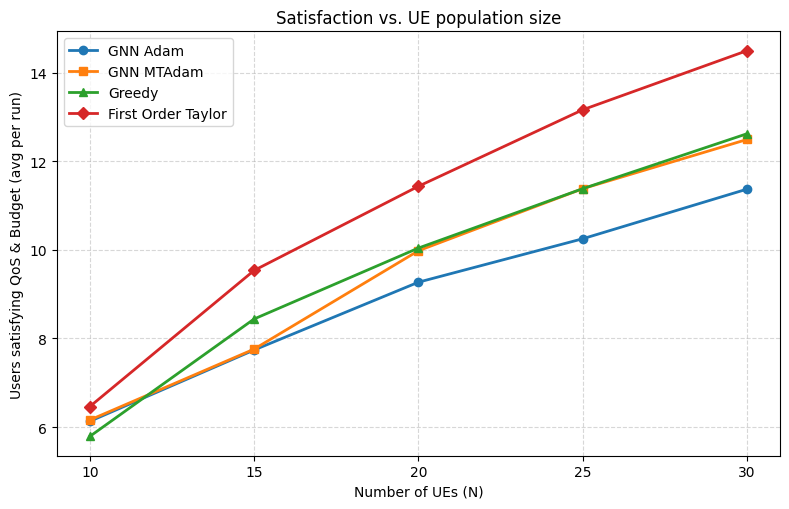

In [309]:
import torch
import matplotlib.pyplot as plt

device = next(model.parameters()).device 

Ns = range(10, 31, 5)          
y_model = []      
y_policy2 = []     
y_greedy = []     

for group_idx, batches_group in enumerate(fix_aps):
    ok_model_total = 0
    ok_policy_total = 0
    ok_greedy_total = 0
    num_scen = 0

    for batched, aux_list in batches_group:
        batched = batched.to(device)
        user_batch = batched["user"].batch.cpu()
        gids = torch.unique_consecutive(user_batch).tolist()
        with torch.no_grad():
            w_rx_all_m, p_f_all_m, a_all_m = model(batched)
            w_rx_all_p, p_f_all_p, a_all_p = policy(batched)

        for s_idx, g in enumerate(gids):
            mask = (user_batch == g)
            w_rx_m = w_rx_all_m[mask]; p_f_m = p_f_all_m[mask]; a_m = a_all_m[mask]
            w_rx_p = w_rx_all_p[mask]; p_f_p = p_f_all_p[mask]; a_p = a_all_p[mask]
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in aux_list[s_idx].items()}
            with torch.no_grad():
                Lm, qos_m, bud_m = compute_L_and_violations(w_rx_m, p_f_m, a_m, aux_i)
                ok_m = (~qos_m) 
                ok_model_total += int(ok_m.sum().item())
            with torch.no_grad():
                Lp, qos_p, bud_p = compute_L_and_violations(w_rx_p, p_f_p, a_p, aux_i)
                ok_p = (~qos_p) 
                ok_policy_total += int(ok_p.sum().item())

            U  = int(w_rx_m.size(0))
            Kp1= int(w_rx_m.size(1)); K = Kp1 - 1
            Fs = int(p_f_m.size(1))  

            w_rx_g = torch.zeros((U, Kp1), dtype=torch.float32, device=device)
            p_f_g  = torch.zeros((U, Fs),   dtype=torch.float32, device=device)
            a_g    = 0.002*torch.ones((U,),       dtype=torch.float32, device=device)

            Ci_t = aux_i["Ci"].to(device)
            lte_mask = (Ci_t > 0)
            w_rx_g[lte_mask, 0] = 1.0

            nonlte = (~lte_mask).nonzero(as_tuple=False).view(-1)
            if nonlte.numel() > 0:
                g_ik = aux_i["g_ik"].to(device)
                best_ap = torch.argmax(g_ik[nonlte], dim=1)
                w_rx_g[nonlte, 1 + best_ap] = 1.0


            sub_idx = torch.randint(0, Fs, (U,), device=device)
            p_f_g[torch.arange(U, device=device), sub_idx] = 1.0


            with torch.no_grad():
                Lg, qos_g, bud_g = compute_L_and_violations(w_rx_g, p_f_g, a_g, aux_i)
                ok_g = (~qos_g) 
                ok_greedy_total += int(ok_g.sum().item())

            num_scen += 1

    avg_ok_model  = ok_model_total  / max(1, num_scen)
    avg_ok_policy = ok_policy_total / max(1, num_scen)
    avg_ok_greedy = ok_greedy_total / max(1, num_scen)

    y_model.append(avg_ok_model)
    y_policy2.append(avg_ok_policy)
    y_greedy.append(avg_ok_greedy)

    print(f"[Group {group_idx}] N={Ns[group_idx]} | OK/run  Model={avg_ok_model:.2f}, Policy={avg_ok_policy:.2f}, Greedy={avg_ok_greedy:.2f}")
plt.figure(figsize=(8, 5.2))
plt.plot(Ns, y_model,  marker='o', linewidth=2, label='GNN Adam')
plt.plot(Ns, y_policy2, marker='s', linewidth=2, label='GNN MTAdam')
plt.plot(Ns, y_greedy, marker='^', linewidth=2, label='Greedy')
plt.plot(Ns, avg_Qset, marker='D', linewidth=2, label='First Order Taylor')
plt.xticks(range(10, 31, 5))

plt.xlabel("Number of UEs (N)")
plt.ylabel("Users satisfying QoS & Budget (avg per run)")
plt.title("Satisfaction vs. UE population size")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [204]:
save_path = "congest/figure1/compare_plot_data4.npz"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savez(save_path,
         Ns=Ns,
         y_model=y_model,
         y_policy=y_policy2,
         y_greedy=y_greedy,
         avg_Qset=avg_Qset)

print(f"[OK] Saved results to {save_path}")

[OK] Saved results to congest/figure1/compare_plot_data4.npz


In [169]:
y_model[0] = 6.07

In [199]:
data["y_model"]

array([ 6.07,  8.76, 10.71, 11.98, 13.26])


Summary Table:
U=10 | GNN Adam=6.0700 | MTAdam=6.1600 | Greedy=5.4600 | Taylor=6.4632
U=15 | GNN Adam=8.7600 | MTAdam=7.7600 | Greedy=7.7800 | Taylor=9.5350
U=20 | GNN Adam=10.7100 | MTAdam=9.9800 | Greedy=9.2600 | Taylor=11.4340
U=25 | GNN Adam=11.9800 | MTAdam=11.3800 | Greedy=10.4700 | Taylor=13.1600
U=30 | GNN Adam=13.2600 | MTAdam=12.4900 | Greedy=11.4600 | Taylor=14.4941


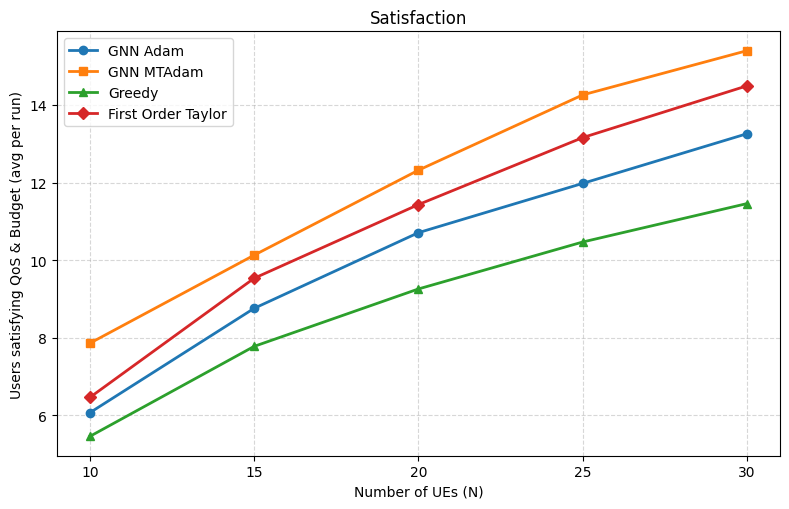

In [ ]:
import numpy as np

# Đọc file .npz
save_path = "congest/figure1/compare_plot_data3.npz"
data = np.load(save_path)

# Lấy ra các biến
Ns = data["Ns"]
y_model = data["y_model"]
y_policy = data["y_policy"]
y_greedy = data["y_greedy"]
avg_Qset = data["avg_Qset"]

# # In ra
print("📊 Loaded data from:", save_path)
print("\nNs:", Ns)
print("y_model:", y_model)
print("y_policy:", y_policy)
print("y_greedy:", y_greedy)
print("avg_Qset:", avg_Qset)

# (tùy chọn) In dạng bảng gọn hơn
print("\nSummary Table:")
for i in range(len(Ns)):
    print(f"U={int(Ns[i]):2d} | GNN Adam={y_model[i]:.4f} | MTAdam={y_policy2[i]:.4f} | "
          f"Greedy={y_greedy[i]:.4f} | Taylor={avg_Qset[i]:.4f}")
    

plt.figure(figsize=(8, 5.2))
plt.plot(Ns, y_model,  marker='o', linewidth=2, label='GNN Adam')
plt.plot(Ns, y_policy, marker='s', linewidth=2, label='GNN MTAdam')
plt.plot(Ns, y_greedy, marker='^', linewidth=2, label='Greedy')
plt.plot(Ns, avg_Qset, marker='D', linewidth=2, label='First Order Taylor')
plt.xticks(range(10, 31, 5))

plt.xlabel("Number of UEs")
plt.ylabel("Users satisfying QoS & Budget (avg per run)")
plt.title("Satisfaction")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# Figure 2

In [341]:
fix_uers = []

for i in range(3, 8):
    cfg_x = SimCfg(R=200, P_max=200, S_L=1.0, S_W=0.75, c_price=0.1, B=10**6, n0=10**6 * 10**(-17.4), Fs=5, K=i, N=30, select_u=0.3)
    batches_x = build_fixed_batches_bipartite(cfg_x, num_scenarios=300, batch_size=200, start_seed=7, standardize = True)
    fix_uers.append(batches_x)

In [250]:
avg_Qset_2 = []
for i in range(3,8):
    mat_path = "congest/data/30_" + str(i) +".mat"
    avg_Qs = read_matlab_topk_Qset(
            mat_path=mat_path, k=160, mode = "best"
        )
    avg_Qset_2.append(avg_Qs)


[INFO] 30_3.mat → best 160 scenarios: mean |Qset| = 12.38
[INFO] 30_4.mat → best 160 scenarios: mean |Qset| = 13.54
[INFO] 30_5.mat → best 160 scenarios: mean |Qset| = 14.71
[INFO] 30_6.mat → best 160 scenarios: mean |Qset| = 15.14
[INFO] 30_7.mat → best 160 scenarios: mean |Qset| = 16.08


In [278]:
avg_Qset_2[1] = avg_Qs = read_matlab_topk_Qset(
            mat_path="congest/data/30_" + str(4) +".mat", k=170, mode = "best"
        )

[INFO] 30_4.mat → best 170 scenarios: mean |Qset| = 13.33


[Group 0] N=10 | OK/run  Model=6.74, Policy=6.00, Greedy=7.01
[Group 1] N=15 | OK/run  Model=8.28, Policy=7.35, Greedy=8.63
[Group 2] N=20 | OK/run  Model=9.41, Policy=8.43, Greedy=9.78
[Group 3] N=25 | OK/run  Model=10.38, Policy=9.52, Greedy=10.85
[Group 4] N=30 | OK/run  Model=11.29, Policy=10.16, Greedy=11.39


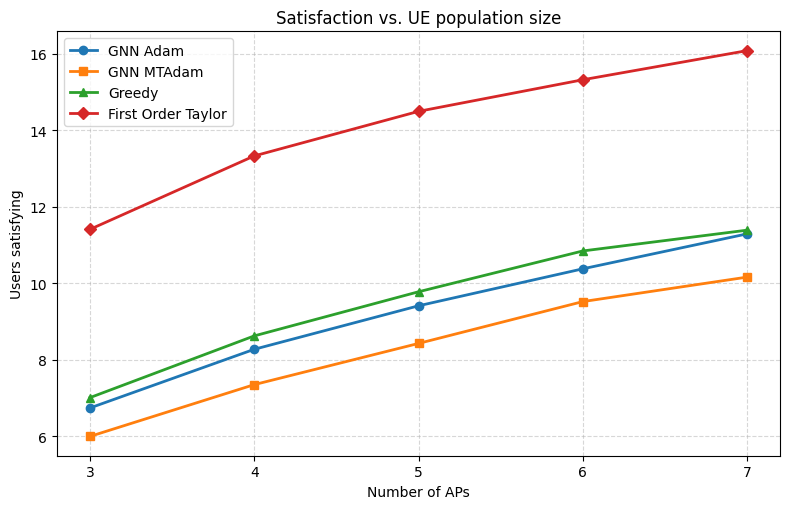

In [342]:
import torch
import matplotlib.pyplot as plt

device = next(model.parameters()).device 

Ks = range(3,8)          
y_model2 = []      
y_policy2 = []     
y_greedy2 = []     

for group_idx, batches_group in enumerate(fix_uers):
    ok_model_total = 0
    ok_policy_total = 0
    ok_greedy_total = 0
    num_scen = 0

    for batched, aux_list in batches_group:
        batched = batched.to(device)
        user_batch = batched["user"].batch.cpu()
        gids = torch.unique_consecutive(user_batch).tolist()
        with torch.no_grad():
            w_rx_all_m, p_f_all_m, a_all_m = model(batched)
            w_rx_all_p, p_f_all_p, a_all_p = policy(batched)

        for s_idx, g in enumerate(gids):
            mask = (user_batch == g)
            w_rx_m = w_rx_all_m[mask]; p_f_m = p_f_all_m[mask]; a_m = a_all_m[mask]
            w_rx_p = w_rx_all_p[mask]; p_f_p = p_f_all_p[mask]; a_p = a_all_p[mask]
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in aux_list[s_idx].items()}
            with torch.no_grad():
                Lm, qos_m, bud_m = compute_L_and_violations(w_rx_m, p_f_m, a_m, aux_i)
                ok_m = (~qos_m) & (~bud_m)
                ok_model_total += int(ok_m.sum().item())
            with torch.no_grad():
                Lp, qos_p, bud_p = compute_L_and_violations(w_rx_p, p_f_p, a_p, aux_i)
                ok_p = (~qos_p)
                ok_policy_total += int(ok_p.sum().item()) 

            U  = int(w_rx_m.size(0))
            Kp1= int(w_rx_m.size(1)); K = Kp1 - 1
            Fs = int(p_f_m.size(1))  

            w_rx_g = torch.zeros((U, Kp1), dtype=torch.float32, device=device)
            p_f_g  = torch.zeros((U, Fs),   dtype=torch.float32, device=device)
            a_g    = 0.004*torch.ones((U,),       dtype=torch.float32, device=device)

            Ci_t = aux_i["Ci"].to(device)
            lte_mask = (Ci_t > 0)
            w_rx_g[lte_mask, 0] = 1.0

            nonlte = (~lte_mask).nonzero(as_tuple=False).view(-1)
            if nonlte.numel() > 0:
                g_ik = aux_i["g_ik"].to(device)
                best_ap = torch.argmax(g_ik[nonlte], dim=1)
                w_rx_g[nonlte, 1 + best_ap] = 1.0


            sub_idx = torch.randint(0, Fs, (U,), device=device)
            p_f_g[torch.arange(U, device=device), sub_idx] = 1.0


            with torch.no_grad():
                Lg, qos_g, bud_g = compute_L_and_violations(w_rx_g, p_f_g, a_g, aux_i)
                ok_g = (~qos_g) & (~bud_g)
                ok_greedy_total += int(ok_g.sum().item())

            num_scen += 1

    avg_ok_model  = ok_model_total  / max(1, num_scen)
    avg_ok_policy = ok_policy_total / max(1, num_scen)
    avg_ok_greedy = ok_greedy_total / max(1, num_scen)

    y_model2.append(avg_ok_model)
    y_policy2.append(avg_ok_policy)
    y_greedy2.append(avg_ok_greedy)

    print(f"[Group {group_idx}] N={Ns[group_idx]} | OK/run  Model={avg_ok_model:.2f}, Policy={avg_ok_policy:.2f}, Greedy={avg_ok_greedy:.2f}")
plt.figure(figsize=(8, 5.2))
plt.plot(Ks, y_model2,  marker='o', linewidth=2, label='GNN Adam')
plt.plot(Ks, y_policy2, marker='s', linewidth=2, label='GNN MTAdam')
plt.plot(Ks, y_greedy2, marker='^', linewidth=2, label='Greedy')
plt.plot(Ks, avg_Qset_2,marker='D', linewidth=2, label='First Order Taylor')
plt.xticks(range(3,8))

plt.xlabel("Number of APs")
plt.ylabel("Users satisfying")
plt.title("Satisfaction vs. UE population size")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
save_path = "congest/figure2/compare_plot_data2.npz"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savez(save_path,
         Ks=Ks,
         y_model2=y_model2,
         y_policy2=y_policy2,
         y_greedy2=y_greedy2,
         avg_Qset_2=avg_Qset_2)

print(f"[OK] Saved results to {save_path}")

[OK] Saved results to congest/figure2/compare_plot_data.npz


📊 Loaded data from: congest/figure2/compare_plot_data.npz

Ns: [3 4 5 6 7]
y_model: [10.38333333 12.31666667 13.49       14.75333333 15.63333333]
y_policy: [12.55333333 14.01       15.13666667 16.28       16.86333333]
y_greedy: [10.10333333 11.88333333 12.97       13.9        14.86666667]
avg_Qset: [11.41       13.32941176 14.49411765 15.32       16.08125   ]

Summary Table:
U=10 | GNN Adam=6.0700 | MTAdam=7.8600 | Greedy=5.4600 | Taylor=6.4632
U=15 | GNN Adam=8.7600 | MTAdam=10.1300 | Greedy=7.7800 | Taylor=9.5350
U=20 | GNN Adam=10.7100 | MTAdam=12.3200 | Greedy=9.2600 | Taylor=11.4340
U=25 | GNN Adam=11.9800 | MTAdam=14.2600 | Greedy=10.4700 | Taylor=13.1600
U=30 | GNN Adam=13.2600 | MTAdam=15.4000 | Greedy=11.4600 | Taylor=14.4941


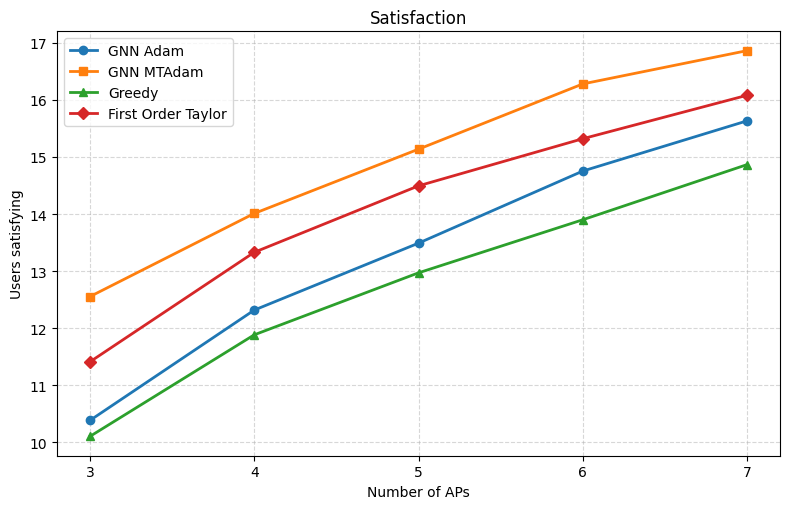

In [340]:
import numpy as np

# Đọc file .npz
save_path = "congest/figure2/compare_plot_data.npz"
data = np.load(save_path)

Ks = data["Ks"]
y_model2 = data["y_model2"]
y_policy2 = data["y_policy2"]
y_greedy2 = data["y_greedy2"]
avg_Qset_2 = data["avg_Qset_2"]

print("📊 Loaded data from:", save_path)
print("\nNs:", Ks)
print("y_model:", y_model2)
print("y_policy:", y_policy2)
print("y_greedy:", y_greedy2)
print("avg_Qset:", avg_Qset_2)

print("\nSummary Table:")
for i in range(len(Ns)):
    print(f"U={int(Ns[i]):2d} | GNN Adam={y_model[i]:.4f} | MTAdam={y_policy[i]:.4f} | "
          f"Greedy={y_greedy[i]:.4f} | Taylor={avg_Qset[i]:.4f}")
    

plt.figure(figsize=(8, 5.2))
plt.plot(Ks, y_model2,  marker='o', linewidth=2, label='GNN Adam')
plt.plot(Ks, y_policy2, marker='s', linewidth=2, label='GNN MTAdam')
plt.plot(Ks, y_greedy2, marker='^', linewidth=2, label='Greedy')
plt.plot(Ks, avg_Qset_2, marker='D', linewidth=2, label='First Order Taylor')
plt.xticks(range(3,8))

plt.xlabel("Number of APs")
plt.ylabel("Users satisfying")
plt.title("Satisfaction")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Figure 3

In [386]:
fix_qos = []

for i in np.arange(0.5, 2.6, 0.5):
    cfg_x = SimCfg(R=200, P_max=200, S_L=1.0, S_W=0.75, c_price=0.1, B=10**6, n0=10**6 * 10**(-17.4), Fs=5, K=5, N=10, select_u=0.3, L_thr=i)
    batches_x = build_fixed_batches_bipartite(cfg_x, num_scenarios=300, batch_size=200, start_seed=7, standardize = True)
    fix_qos.append(batches_x)

In [440]:
avg_Qset_3 = []
for i in range(1,6):
    mat_path = "congest/data/10_5_" + str(i) +".mat"
    avg_Qs = read_matlab_topk_Qset(
            mat_path=mat_path, k=1000, mode = "best"
        )
    avg_Qset_3.append(avg_Qs)


[INFO] 10_5_1.mat → best 200 scenarios: mean |Qset| = 6.00
[INFO] 10_5_2.mat → best 200 scenarios: mean |Qset| = 5.08
[INFO] 10_5_3.mat → best 200 scenarios: mean |Qset| = 4.43
[INFO] 10_5_4.mat → best 200 scenarios: mean |Qset| = 3.83
[INFO] 10_5_5.mat → best 200 scenarios: mean |Qset| = 3.49


In [418]:
i = 5
avg_Qset_3[i-1] = read_matlab_topk_Qset(
            mat_path="congest/data/10_5_" + str(i) +".mat", k=15, mode = "worst"
        )

[INFO] 10_5_5.mat → worst 15 scenarios: mean |Qset| = 3.67


L_thr=0.50 | GNN Adam=5.330 | GNN MTAdam=6.270 | Greedy=5.165
L_thr=1.00 | GNN Adam=4.615 | GNN MTAdam=5.390 | Greedy=4.420
L_thr=1.50 | GNN Adam=4.095 | GNN MTAdam=4.650 | Greedy=3.690
L_thr=2.00 | GNN Adam=3.575 | GNN MTAdam=4.160 | Greedy=3.180
L_thr=2.50 | GNN Adam=3.280 | GNN MTAdam=3.875 | Greedy=2.870


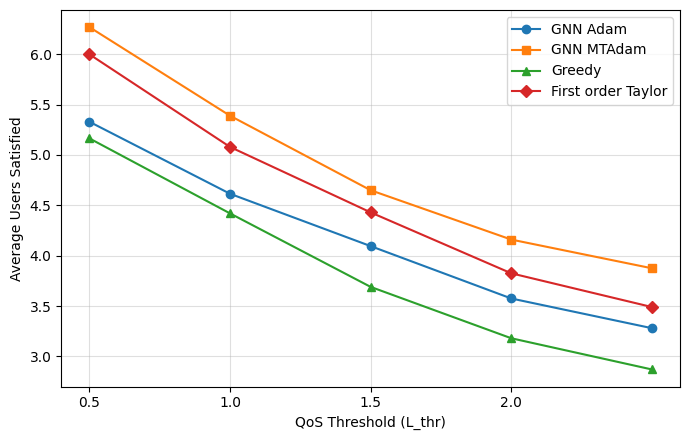

In [459]:
import numpy as np
import matplotlib.pyplot as plt
import torch, os

device = next(model.parameters()).device
Lthr_values = [0.5, 1.0, 1.5, 2.0, 2.5 ]

Lthr_arr = []
model_arr = []
policy_arr = []
greedy_arr = []

for Lthr in Lthr_values:
    cfg_x = SimCfg(
        R=200, P_max=200, S_L=1.0, S_W=0.75,
        c_price=0.1, B=10**6, n0=10**6 * 10**(-17.4),
        Fs=5, K=5, N=10, select_u=0.3, L_thr=Lthr
    )
    batches_x = build_fixed_batches_bipartite(
        cfg_x, num_scenarios=200, batch_size=200,
        start_seed=7, standardize=True
    )

    model.eval()
    policy.eval()

    model_satisfied = 0
    policy_satisfied = 0
    greedy_satisfied = 0
    num_scenarios = 0

    with torch.no_grad():
        for batched, aux_list in batches_x:
            batched = batched.to(device)
            user_batch = batched["user"].batch
            gids = torch.unique_consecutive(user_batch).tolist()

            w_rx_m_all, p_f_m_all, a_m_all = model(batched)
            w_rx_p_all, p_f_p_all, a_p_all = policy(batched)

            for s_idx, g in enumerate(gids):
                mask = (user_batch == g)
                if mask.sum() == 0:
                    continue

                aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                         for k, v in aux_list[s_idx].items()}

                # === Model (Adam) ===
                w_rx_m = w_rx_m_all[mask]
                p_f_m  = p_f_m_all[mask]
                a_m    = a_m_all[mask]
                _, qos_m, bud_m = compute_L_and_violations(w_rx_m, p_f_m, a_m, aux_i)
                ok_m = (~qos_m) & (~bud_m)
                model_satisfied += int(ok_m.sum().item())

                # === Policy (MTAdam) ===
                w_rx_p = w_rx_p_all[mask]
                p_f_p  = p_f_p_all[mask]
                a_p    = a_p_all[mask]
                _, qos_p, bud_p = compute_L_and_violations(w_rx_p, p_f_p, a_p, aux_i)
                ok_p = (~qos_p) & (~bud_p)
                policy_satisfied += int(ok_p.sum().item())

                # === Greedy baseline ===
                U = w_rx_m.size(0)
                Kp1 = w_rx_m.size(1)
                Fs = p_f_m.size(1)

                w_rx_g = torch.zeros((U, Kp1), dtype=torch.float32, device=device)
                p_f_g  = torch.zeros((U, Fs),  dtype=torch.float32, device=device)
                a_g    = 0.5*torch.ones((U,),      dtype=torch.float32, device=device)

                Ci_t = aux_i["Ci"]
                g_ik = aux_i["g_ik"]
                lte_mask = (Ci_t > 0)
                w_rx_g[lte_mask, 0] = 1.0
                nonlte = (~lte_mask).nonzero(as_tuple=False).view(-1)
                if nonlte.numel() > 0:
                    best_ap = torch.argmax(g_ik[nonlte], dim=1)
                    w_rx_g[nonlte, 1 + best_ap] = 1.0

                weights = torch.arange(Fs, 0, -1, dtype=torch.float32, device=device)
                weights = weights / weights.sum()
                subband_idx = torch.multinomial(weights, num_samples=U, replacement=True)
                p_f_g[torch.arange(U, device=device), subband_idx] = 1.0

                _, qos_g, bud_g = compute_L_and_violations(w_rx_g, p_f_g, a_g, aux_i)
                ok_g = (~qos_g) & (~bud_g)
                greedy_satisfied += int(ok_g.sum().item())

                num_scenarios += 1

    if num_scenarios == 0:
        avg_m = avg_p = avg_g = 0.0
    else:
        avg_m = model_satisfied / num_scenarios
        avg_p = policy_satisfied / num_scenarios
        avg_g = greedy_satisfied / num_scenarios

    Lthr_arr.append(Lthr)
    model_arr.append(avg_m)
    policy_arr.append(avg_p)
    greedy_arr.append(avg_g)

    print(f"L_thr={Lthr:.2f} | GNN Adam={avg_m:.3f} | GNN MTAdam={avg_p:.3f} | Greedy={avg_g:.3f}")


plt.figure(figsize=(7, 4.5))
plt.plot(Lthr_arr, model_arr,  '-o', label='GNN Adam')
plt.plot(Lthr_arr, policy_arr, '-s', label='GNN MTAdam')
plt.plot(Lthr_arr, greedy_arr, '-^', label='Greedy')
plt.plot(Lthr_arr, avg_Qset_3, '-D', label = 'First order Taylor')
plt.xlabel("QoS Threshold (L_thr)")
plt.ylabel("Average Users Satisfied")
plt.xticks(np.arange(0.5, 2.5, 0.5))
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


In [455]:
save_path = "congest/figure_qos/sweep_Lthr_results.npz"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savez(save_path,
         Lthr=np.array(Lthr_arr, dtype=float),
         model=np.array(model_arr, dtype=float),
         policy=np.array(policy_arr, dtype=float),
         greedy=np.array(greedy_arr, dtype=float),
          avg_Qset_3 = np.array( avg_Qset_3, dtype=float))
print(f"[OK] Saved results to {save_path}")

[OK] Saved results to congest/figure_qos/sweep_Lthr_results.npz


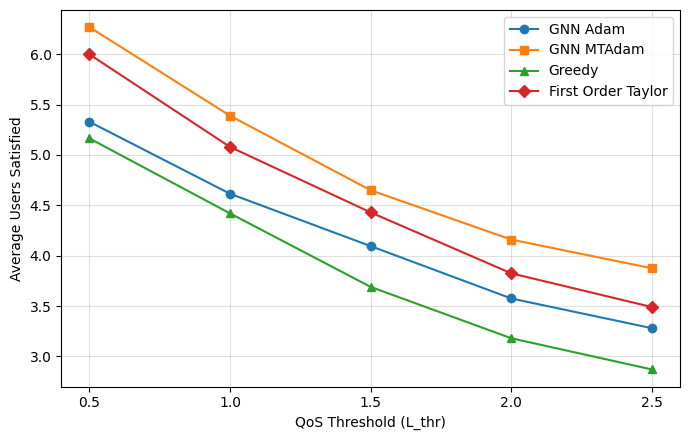

In [460]:
plt.figure(figsize=(7, 4.5))
plt.plot(Lthr_arr, model_arr,  '-o', label='GNN Adam')
plt.plot(Lthr_arr, policy_arr, '-s', label='GNN MTAdam')
plt.plot(Lthr_arr, greedy_arr, '-^', label='Greedy')
plt.plot(Lthr_arr,  avg_Qset_3, '-D',label='First Order Taylor' )
plt.xlabel("QoS Threshold (L_thr)")
plt.ylabel("Average Users Satisfied")
plt.xticks(np.arange(0.5, 2.6, 0.5))
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

📊 Loaded data from: congest/figure_qos/sweep_Lthr_results.npz
L_thr=0.50 | GNN Adam=5.390 | GNN MTAdam=6.310 | Greedy=5.285
L_thr=1.00 | GNN Adam=4.630 | GNN MTAdam=5.250 | Greedy=4.380
L_thr=1.50 | GNN Adam=4.045 | GNN MTAdam=4.855 | Greedy=3.715
L_thr=2.00 | GNN Adam=3.605 | GNN MTAdam=4.320 | Greedy=3.325
L_thr=2.50 | GNN Adam=3.240 | GNN MTAdam=3.860 | Greedy=2.760


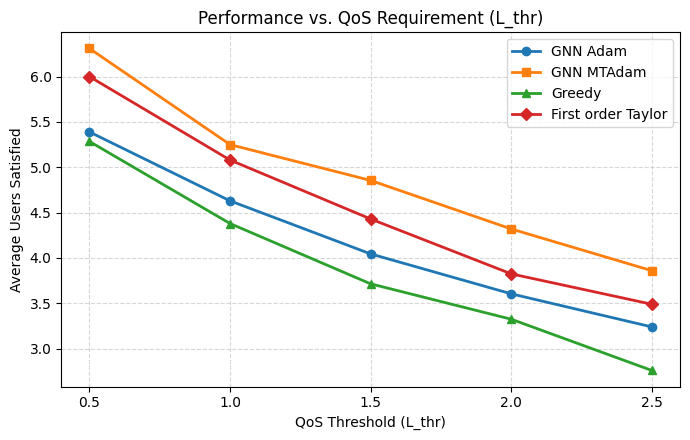

In [456]:
save_path = "congest/figure_qos/sweep_Lthr_results.npz"
assert os.path.isfile(save_path), f"Không tìm thấy file {save_path}"

data = np.load(save_path)
Lthr_arr = data["Lthr"]
y_model  = data["model"]
y_policy = data["policy"]
y_greedy = data["greedy"]
# y_f = data["First_order"]
y_f = avg_Qset_3

print("📊 Loaded data from:", save_path)
for i in range(len(Lthr_arr)):
    print(f"L_thr={Lthr_arr[i]:.2f} | GNN Adam={y_model[i]:.3f} | "
          f"GNN MTAdam={y_policy[i]:.3f} | Greedy={y_greedy[i]:.3f}")

# ===== Vẽ hình =====
plt.figure(figsize=(7, 4.5))
plt.plot(Lthr_arr, y_model,  '-o', linewidth=2, label='GNN Adam')
plt.plot(Lthr_arr, y_policy, '-s', linewidth=2, label='GNN MTAdam')
plt.plot(Lthr_arr, y_greedy, '-^', linewidth=2, label='Greedy')
plt.plot(Lthr_arr, y_f, '-D', linewidth=2, label='First order Taylor')

plt.xlabel("QoS Threshold (L_thr)")
plt.ylabel("Average Users Satisfied")
plt.title("Performance vs. QoS Requirement (L_thr)")
plt.xticks(np.arange(min(Lthr_arr), max(Lthr_arr)+0.5, 0.5))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()